In [1]:
import numpy as np

def get_y(x):
    return 10 + x*x


def sample_data(n=10000, scale=100):
    data = []

    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])

    return np.array(data)

In [2]:
def generator(Z,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2,2)

    return out

In [3]:
def discriminator(X,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,2)
        out = tf.layers.dense(h3,1)

    return out, h3

In [4]:
import tensorflow as tf

In [5]:
X = tf.placeholder(tf.float32,[None,2])
Z = tf.placeholder(tf.float32,[None,2])

In [6]:
G_sample = generator(Z)
r_logits, r_rep = discriminator(X)
f_logits, g_rep = discriminator(G_sample,reuse=True)

In [7]:
disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))


In [8]:
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step


In [49]:
batch_size=10000

In [40]:
def sample_Z(bs, sh):
    return np.random.uniform(0, 1, (bs,sh))

In [41]:
if "sess" in dir():
    sess.close()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [50]:
for i in range(100001):
    X_batch = sample_data(n=batch_size)
    Z_batch = sample_Z(batch_size, 2)
    _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
    _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

    print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))

Iterations: 0	 Discriminator loss: 1.3863	 Generator loss: 0.6984
Iterations: 1	 Discriminator loss: 1.3862	 Generator loss: 0.6913
Iterations: 2	 Discriminator loss: 1.3861	 Generator loss: 0.6928
Iterations: 3	 Discriminator loss: 1.3859	 Generator loss: 0.6932
Iterations: 4	 Discriminator loss: 1.3861	 Generator loss: 0.6920
Iterations: 5	 Discriminator loss: 1.3861	 Generator loss: 0.6846
Iterations: 6	 Discriminator loss: 1.3860	 Generator loss: 0.6983
Iterations: 7	 Discriminator loss: 1.3860	 Generator loss: 0.6880
Iterations: 8	 Discriminator loss: 1.3859	 Generator loss: 0.7084
Iterations: 9	 Discriminator loss: 1.3862	 Generator loss: 0.6764
Iterations: 10	 Discriminator loss: 1.3863	 Generator loss: 0.6995
Iterations: 11	 Discriminator loss: 1.3858	 Generator loss: 0.6912
Iterations: 12	 Discriminator loss: 1.3859	 Generator loss: 0.6904
Iterations: 13	 Discriminator loss: 1.3858	 Generator loss: 0.7115
Iterations: 14	 Discriminator loss: 1.3864	 Generator loss: 0.6672
Itera

Iterations: 129	 Discriminator loss: 1.3857	 Generator loss: 0.6956
Iterations: 130	 Discriminator loss: 1.3859	 Generator loss: 0.6892
Iterations: 131	 Discriminator loss: 1.3859	 Generator loss: 0.6920
Iterations: 132	 Discriminator loss: 1.3857	 Generator loss: 0.7067
Iterations: 133	 Discriminator loss: 1.3864	 Generator loss: 0.6827
Iterations: 134	 Discriminator loss: 1.3863	 Generator loss: 0.7064
Iterations: 135	 Discriminator loss: 1.3865	 Generator loss: 0.6911
Iterations: 136	 Discriminator loss: 1.3862	 Generator loss: 0.6904
Iterations: 137	 Discriminator loss: 1.3859	 Generator loss: 0.6917
Iterations: 138	 Discriminator loss: 1.3859	 Generator loss: 0.6906
Iterations: 139	 Discriminator loss: 1.3857	 Generator loss: 0.6948
Iterations: 140	 Discriminator loss: 1.3859	 Generator loss: 0.6928
Iterations: 141	 Discriminator loss: 1.3857	 Generator loss: 0.6847
Iterations: 142	 Discriminator loss: 1.3863	 Generator loss: 0.7209
Iterations: 143	 Discriminator loss: 1.3872	 Gen

Iterations: 250	 Discriminator loss: 1.3863	 Generator loss: 0.7051
Iterations: 251	 Discriminator loss: 1.3862	 Generator loss: 0.6887
Iterations: 252	 Discriminator loss: 1.3859	 Generator loss: 0.6974
Iterations: 253	 Discriminator loss: 1.3860	 Generator loss: 0.6921
Iterations: 254	 Discriminator loss: 1.3859	 Generator loss: 0.7013
Iterations: 255	 Discriminator loss: 1.3857	 Generator loss: 0.6936
Iterations: 256	 Discriminator loss: 1.3857	 Generator loss: 0.7001
Iterations: 257	 Discriminator loss: 1.3860	 Generator loss: 0.6814
Iterations: 258	 Discriminator loss: 1.3865	 Generator loss: 0.7193
Iterations: 259	 Discriminator loss: 1.3872	 Generator loss: 0.6679
Iterations: 260	 Discriminator loss: 1.3868	 Generator loss: 0.6931
Iterations: 261	 Discriminator loss: 1.3860	 Generator loss: 0.6960
Iterations: 262	 Discriminator loss: 1.3860	 Generator loss: 0.6913
Iterations: 263	 Discriminator loss: 1.3859	 Generator loss: 0.6956
Iterations: 264	 Discriminator loss: 1.3860	 Gen

Iterations: 377	 Discriminator loss: 1.3859	 Generator loss: 0.6994
Iterations: 378	 Discriminator loss: 1.3859	 Generator loss: 0.6871
Iterations: 379	 Discriminator loss: 1.3859	 Generator loss: 0.7061
Iterations: 380	 Discriminator loss: 1.3860	 Generator loss: 0.6589
Iterations: 381	 Discriminator loss: 1.3880	 Generator loss: 0.7282
Iterations: 382	 Discriminator loss: 1.3877	 Generator loss: 0.6869
Iterations: 383	 Discriminator loss: 1.3858	 Generator loss: 0.6820
Iterations: 384	 Discriminator loss: 1.3864	 Generator loss: 0.6942
Iterations: 385	 Discriminator loss: 1.3858	 Generator loss: 0.6928
Iterations: 386	 Discriminator loss: 1.3858	 Generator loss: 0.6879
Iterations: 387	 Discriminator loss: 1.3857	 Generator loss: 0.6900
Iterations: 388	 Discriminator loss: 1.3858	 Generator loss: 0.6984
Iterations: 389	 Discriminator loss: 1.3859	 Generator loss: 0.6966
Iterations: 390	 Discriminator loss: 1.3859	 Generator loss: 0.6905
Iterations: 391	 Discriminator loss: 1.3861	 Gen

Iterations: 503	 Discriminator loss: 1.3858	 Generator loss: 0.6972
Iterations: 504	 Discriminator loss: 1.3860	 Generator loss: 0.7091
Iterations: 505	 Discriminator loss: 1.3863	 Generator loss: 0.6746
Iterations: 506	 Discriminator loss: 1.3861	 Generator loss: 0.7079
Iterations: 507	 Discriminator loss: 1.3864	 Generator loss: 0.6771
Iterations: 508	 Discriminator loss: 1.3860	 Generator loss: 0.6950
Iterations: 509	 Discriminator loss: 1.3858	 Generator loss: 0.7005
Iterations: 510	 Discriminator loss: 1.3861	 Generator loss: 0.6833
Iterations: 511	 Discriminator loss: 1.3860	 Generator loss: 0.7002
Iterations: 512	 Discriminator loss: 1.3859	 Generator loss: 0.6863
Iterations: 513	 Discriminator loss: 1.3860	 Generator loss: 0.7161
Iterations: 514	 Discriminator loss: 1.3874	 Generator loss: 0.6685
Iterations: 515	 Discriminator loss: 1.3869	 Generator loss: 0.6939
Iterations: 516	 Discriminator loss: 1.3860	 Generator loss: 0.6928
Iterations: 517	 Discriminator loss: 1.3859	 Gen

Iterations: 624	 Discriminator loss: 1.3858	 Generator loss: 0.7082
Iterations: 625	 Discriminator loss: 1.3861	 Generator loss: 0.6735
Iterations: 626	 Discriminator loss: 1.3868	 Generator loss: 0.7129
Iterations: 627	 Discriminator loss: 1.3865	 Generator loss: 0.6883
Iterations: 628	 Discriminator loss: 1.3859	 Generator loss: 0.6967
Iterations: 629	 Discriminator loss: 1.3859	 Generator loss: 0.6937
Iterations: 630	 Discriminator loss: 1.3858	 Generator loss: 0.6998
Iterations: 631	 Discriminator loss: 1.3858	 Generator loss: 0.6926
Iterations: 632	 Discriminator loss: 1.3861	 Generator loss: 0.6770
Iterations: 633	 Discriminator loss: 1.3865	 Generator loss: 0.7073
Iterations: 634	 Discriminator loss: 1.3863	 Generator loss: 0.6812
Iterations: 635	 Discriminator loss: 1.3861	 Generator loss: 0.6985
Iterations: 636	 Discriminator loss: 1.3859	 Generator loss: 0.6898
Iterations: 637	 Discriminator loss: 1.3856	 Generator loss: 0.6913
Iterations: 638	 Discriminator loss: 1.3858	 Gen

Iterations: 746	 Discriminator loss: 1.3860	 Generator loss: 0.6933
Iterations: 747	 Discriminator loss: 1.3859	 Generator loss: 0.6959
Iterations: 748	 Discriminator loss: 1.3858	 Generator loss: 0.6964
Iterations: 749	 Discriminator loss: 1.3858	 Generator loss: 0.6926
Iterations: 750	 Discriminator loss: 1.3857	 Generator loss: 0.6836
Iterations: 751	 Discriminator loss: 1.3859	 Generator loss: 0.7051
Iterations: 752	 Discriminator loss: 1.3862	 Generator loss: 0.6858
Iterations: 753	 Discriminator loss: 1.3859	 Generator loss: 0.6898
Iterations: 754	 Discriminator loss: 1.3858	 Generator loss: 0.6918
Iterations: 755	 Discriminator loss: 1.3859	 Generator loss: 0.6824
Iterations: 756	 Discriminator loss: 1.3862	 Generator loss: 0.6978
Iterations: 757	 Discriminator loss: 1.3858	 Generator loss: 0.6875
Iterations: 758	 Discriminator loss: 1.3858	 Generator loss: 0.7070
Iterations: 759	 Discriminator loss: 1.3859	 Generator loss: 0.6812
Iterations: 760	 Discriminator loss: 1.3861	 Gen

Iterations: 869	 Discriminator loss: 1.3859	 Generator loss: 0.6905
Iterations: 870	 Discriminator loss: 1.3857	 Generator loss: 0.6956
Iterations: 871	 Discriminator loss: 1.3856	 Generator loss: 0.6906
Iterations: 872	 Discriminator loss: 1.3860	 Generator loss: 0.7080
Iterations: 873	 Discriminator loss: 1.3863	 Generator loss: 0.6759
Iterations: 874	 Discriminator loss: 1.3864	 Generator loss: 0.7168
Iterations: 875	 Discriminator loss: 1.3872	 Generator loss: 0.6775
Iterations: 876	 Discriminator loss: 1.3863	 Generator loss: 0.6920
Iterations: 877	 Discriminator loss: 1.3861	 Generator loss: 0.6974
Iterations: 878	 Discriminator loss: 1.3860	 Generator loss: 0.6948
Iterations: 879	 Discriminator loss: 1.3859	 Generator loss: 0.6959
Iterations: 880	 Discriminator loss: 1.3860	 Generator loss: 0.6925
Iterations: 881	 Discriminator loss: 1.3858	 Generator loss: 0.6956
Iterations: 882	 Discriminator loss: 1.3858	 Generator loss: 0.6915
Iterations: 883	 Discriminator loss: 1.3860	 Gen

Iterations: 994	 Discriminator loss: 1.3858	 Generator loss: 0.6948
Iterations: 995	 Discriminator loss: 1.3863	 Generator loss: 0.6996
Iterations: 996	 Discriminator loss: 1.3862	 Generator loss: 0.7007
Iterations: 997	 Discriminator loss: 1.3859	 Generator loss: 0.6827
Iterations: 998	 Discriminator loss: 1.3862	 Generator loss: 0.7151
Iterations: 999	 Discriminator loss: 1.3865	 Generator loss: 0.6722
Iterations: 1000	 Discriminator loss: 1.3863	 Generator loss: 0.7100
Iterations: 1001	 Discriminator loss: 1.3864	 Generator loss: 0.6884
Iterations: 1002	 Discriminator loss: 1.3859	 Generator loss: 0.6905
Iterations: 1003	 Discriminator loss: 1.3858	 Generator loss: 0.6958
Iterations: 1004	 Discriminator loss: 1.3859	 Generator loss: 0.7082
Iterations: 1005	 Discriminator loss: 1.3861	 Generator loss: 0.6829
Iterations: 1006	 Discriminator loss: 1.3862	 Generator loss: 0.7158
Iterations: 1007	 Discriminator loss: 1.3866	 Generator loss: 0.6845
Iterations: 1008	 Discriminator loss: 1.

Iterations: 1116	 Discriminator loss: 1.3863	 Generator loss: 0.6957
Iterations: 1117	 Discriminator loss: 1.3859	 Generator loss: 0.6919
Iterations: 1118	 Discriminator loss: 1.3859	 Generator loss: 0.6956
Iterations: 1119	 Discriminator loss: 1.3860	 Generator loss: 0.6899
Iterations: 1120	 Discriminator loss: 1.3861	 Generator loss: 0.6948
Iterations: 1121	 Discriminator loss: 1.3860	 Generator loss: 0.6956
Iterations: 1122	 Discriminator loss: 1.3859	 Generator loss: 0.6916
Iterations: 1123	 Discriminator loss: 1.3861	 Generator loss: 0.6947
Iterations: 1124	 Discriminator loss: 1.3860	 Generator loss: 0.7003
Iterations: 1125	 Discriminator loss: 1.3860	 Generator loss: 0.6792
Iterations: 1126	 Discriminator loss: 1.3863	 Generator loss: 0.7172
Iterations: 1127	 Discriminator loss: 1.3865	 Generator loss: 0.6706
Iterations: 1128	 Discriminator loss: 1.3870	 Generator loss: 0.7051
Iterations: 1129	 Discriminator loss: 1.3864	 Generator loss: 0.6913
Iterations: 1130	 Discriminator lo

Iterations: 1241	 Discriminator loss: 1.3859	 Generator loss: 0.6881
Iterations: 1242	 Discriminator loss: 1.3860	 Generator loss: 0.7077
Iterations: 1243	 Discriminator loss: 1.3862	 Generator loss: 0.6671
Iterations: 1244	 Discriminator loss: 1.3872	 Generator loss: 0.7141
Iterations: 1245	 Discriminator loss: 1.3865	 Generator loss: 0.6931
Iterations: 1246	 Discriminator loss: 1.3859	 Generator loss: 0.6942
Iterations: 1247	 Discriminator loss: 1.3859	 Generator loss: 0.6927
Iterations: 1248	 Discriminator loss: 1.3857	 Generator loss: 0.6864
Iterations: 1249	 Discriminator loss: 1.3860	 Generator loss: 0.6916
Iterations: 1250	 Discriminator loss: 1.3860	 Generator loss: 0.6917
Iterations: 1251	 Discriminator loss: 1.3859	 Generator loss: 0.7027
Iterations: 1252	 Discriminator loss: 1.3860	 Generator loss: 0.6935
Iterations: 1253	 Discriminator loss: 1.3861	 Generator loss: 0.6951
Iterations: 1254	 Discriminator loss: 1.3859	 Generator loss: 0.6939
Iterations: 1255	 Discriminator lo

Iterations: 1364	 Discriminator loss: 1.3863	 Generator loss: 0.6772
Iterations: 1365	 Discriminator loss: 1.3865	 Generator loss: 0.6945
Iterations: 1366	 Discriminator loss: 1.3858	 Generator loss: 0.6936
Iterations: 1367	 Discriminator loss: 1.3860	 Generator loss: 0.6901
Iterations: 1368	 Discriminator loss: 1.3860	 Generator loss: 0.6967
Iterations: 1369	 Discriminator loss: 1.3862	 Generator loss: 0.6792
Iterations: 1370	 Discriminator loss: 1.3866	 Generator loss: 0.7090
Iterations: 1371	 Discriminator loss: 1.3865	 Generator loss: 0.6849
Iterations: 1372	 Discriminator loss: 1.3861	 Generator loss: 0.6927
Iterations: 1373	 Discriminator loss: 1.3860	 Generator loss: 0.6980
Iterations: 1374	 Discriminator loss: 1.3860	 Generator loss: 0.6880
Iterations: 1375	 Discriminator loss: 1.3860	 Generator loss: 0.7052
Iterations: 1376	 Discriminator loss: 1.3862	 Generator loss: 0.6794
Iterations: 1377	 Discriminator loss: 1.3863	 Generator loss: 0.7046
Iterations: 1378	 Discriminator lo

Iterations: 1487	 Discriminator loss: 1.3861	 Generator loss: 0.6830
Iterations: 1488	 Discriminator loss: 1.3862	 Generator loss: 0.7173
Iterations: 1489	 Discriminator loss: 1.3867	 Generator loss: 0.6729
Iterations: 1490	 Discriminator loss: 1.3872	 Generator loss: 0.7055
Iterations: 1491	 Discriminator loss: 1.3863	 Generator loss: 0.6939
Iterations: 1492	 Discriminator loss: 1.3859	 Generator loss: 0.6984
Iterations: 1493	 Discriminator loss: 1.3860	 Generator loss: 0.6928
Iterations: 1494	 Discriminator loss: 1.3860	 Generator loss: 0.6912
Iterations: 1495	 Discriminator loss: 1.3860	 Generator loss: 0.6894
Iterations: 1496	 Discriminator loss: 1.3859	 Generator loss: 0.6952
Iterations: 1497	 Discriminator loss: 1.3858	 Generator loss: 0.6880
Iterations: 1498	 Discriminator loss: 1.3859	 Generator loss: 0.6902
Iterations: 1499	 Discriminator loss: 1.3858	 Generator loss: 0.7134
Iterations: 1500	 Discriminator loss: 1.3866	 Generator loss: 0.6667
Iterations: 1501	 Discriminator lo

Iterations: 1609	 Discriminator loss: 1.3861	 Generator loss: 0.6993
Iterations: 1610	 Discriminator loss: 1.3859	 Generator loss: 0.7022
Iterations: 1611	 Discriminator loss: 1.3860	 Generator loss: 0.6882
Iterations: 1612	 Discriminator loss: 1.3861	 Generator loss: 0.6915
Iterations: 1613	 Discriminator loss: 1.3860	 Generator loss: 0.6875
Iterations: 1614	 Discriminator loss: 1.3863	 Generator loss: 0.7109
Iterations: 1615	 Discriminator loss: 1.3859	 Generator loss: 0.6825
Iterations: 1616	 Discriminator loss: 1.3866	 Generator loss: 0.7128
Iterations: 1617	 Discriminator loss: 1.3867	 Generator loss: 0.6855
Iterations: 1618	 Discriminator loss: 1.3863	 Generator loss: 0.6946
Iterations: 1619	 Discriminator loss: 1.3859	 Generator loss: 0.6933
Iterations: 1620	 Discriminator loss: 1.3861	 Generator loss: 0.6968
Iterations: 1621	 Discriminator loss: 1.3859	 Generator loss: 0.6959
Iterations: 1622	 Discriminator loss: 1.3857	 Generator loss: 0.6839
Iterations: 1623	 Discriminator lo

Iterations: 1731	 Discriminator loss: 1.3860	 Generator loss: 0.6977
Iterations: 1732	 Discriminator loss: 1.3863	 Generator loss: 0.6871
Iterations: 1733	 Discriminator loss: 1.3861	 Generator loss: 0.6950
Iterations: 1734	 Discriminator loss: 1.3861	 Generator loss: 0.6856
Iterations: 1735	 Discriminator loss: 1.3860	 Generator loss: 0.7018
Iterations: 1736	 Discriminator loss: 1.3860	 Generator loss: 0.6860
Iterations: 1737	 Discriminator loss: 1.3861	 Generator loss: 0.6962
Iterations: 1738	 Discriminator loss: 1.3857	 Generator loss: 0.7010
Iterations: 1739	 Discriminator loss: 1.3858	 Generator loss: 0.6734
Iterations: 1740	 Discriminator loss: 1.3865	 Generator loss: 0.7196
Iterations: 1741	 Discriminator loss: 1.3871	 Generator loss: 0.6768
Iterations: 1742	 Discriminator loss: 1.3865	 Generator loss: 0.6960
Iterations: 1743	 Discriminator loss: 1.3860	 Generator loss: 0.6945
Iterations: 1744	 Discriminator loss: 1.3859	 Generator loss: 0.6882
Iterations: 1745	 Discriminator lo

Iterations: 1855	 Discriminator loss: 1.3866	 Generator loss: 0.6738
Iterations: 1856	 Discriminator loss: 1.3866	 Generator loss: 0.7017
Iterations: 1857	 Discriminator loss: 1.3862	 Generator loss: 0.6946
Iterations: 1858	 Discriminator loss: 1.3862	 Generator loss: 0.6880
Iterations: 1859	 Discriminator loss: 1.3860	 Generator loss: 0.6924
Iterations: 1860	 Discriminator loss: 1.3861	 Generator loss: 0.6931
Iterations: 1861	 Discriminator loss: 1.3858	 Generator loss: 0.6986
Iterations: 1862	 Discriminator loss: 1.3860	 Generator loss: 0.6857
Iterations: 1863	 Discriminator loss: 1.3859	 Generator loss: 0.6947
Iterations: 1864	 Discriminator loss: 1.3859	 Generator loss: 0.6957
Iterations: 1865	 Discriminator loss: 1.3861	 Generator loss: 0.6883
Iterations: 1866	 Discriminator loss: 1.3857	 Generator loss: 0.7024
Iterations: 1867	 Discriminator loss: 1.3865	 Generator loss: 0.6801
Iterations: 1868	 Discriminator loss: 1.3860	 Generator loss: 0.7128
Iterations: 1869	 Discriminator lo

Iterations: 1974	 Discriminator loss: 1.3862	 Generator loss: 0.7158
Iterations: 1975	 Discriminator loss: 1.3864	 Generator loss: 0.6790
Iterations: 1976	 Discriminator loss: 1.3861	 Generator loss: 0.6972
Iterations: 1977	 Discriminator loss: 1.3858	 Generator loss: 0.6943
Iterations: 1978	 Discriminator loss: 1.3859	 Generator loss: 0.7021
Iterations: 1979	 Discriminator loss: 1.3860	 Generator loss: 0.6877
Iterations: 1980	 Discriminator loss: 1.3859	 Generator loss: 0.6889
Iterations: 1981	 Discriminator loss: 1.3858	 Generator loss: 0.6811
Iterations: 1982	 Discriminator loss: 1.3862	 Generator loss: 0.7067
Iterations: 1983	 Discriminator loss: 1.3862	 Generator loss: 0.6801
Iterations: 1984	 Discriminator loss: 1.3864	 Generator loss: 0.7121
Iterations: 1985	 Discriminator loss: 1.3865	 Generator loss: 0.6838
Iterations: 1986	 Discriminator loss: 1.3860	 Generator loss: 0.6978
Iterations: 1987	 Discriminator loss: 1.3858	 Generator loss: 0.6943
Iterations: 1988	 Discriminator lo

Iterations: 2096	 Discriminator loss: 1.3860	 Generator loss: 0.6952
Iterations: 2097	 Discriminator loss: 1.3860	 Generator loss: 0.6911
Iterations: 2098	 Discriminator loss: 1.3858	 Generator loss: 0.6880
Iterations: 2099	 Discriminator loss: 1.3859	 Generator loss: 0.7032
Iterations: 2100	 Discriminator loss: 1.3859	 Generator loss: 0.6808
Iterations: 2101	 Discriminator loss: 1.3860	 Generator loss: 0.7078
Iterations: 2102	 Discriminator loss: 1.3858	 Generator loss: 0.6799
Iterations: 2103	 Discriminator loss: 1.3861	 Generator loss: 0.7124
Iterations: 2104	 Discriminator loss: 1.3862	 Generator loss: 0.6808
Iterations: 2105	 Discriminator loss: 1.3862	 Generator loss: 0.7053
Iterations: 2106	 Discriminator loss: 1.3860	 Generator loss: 0.6918
Iterations: 2107	 Discriminator loss: 1.3860	 Generator loss: 0.6939
Iterations: 2108	 Discriminator loss: 1.3857	 Generator loss: 0.6946
Iterations: 2109	 Discriminator loss: 1.3860	 Generator loss: 0.7034
Iterations: 2110	 Discriminator lo

Iterations: 2215	 Discriminator loss: 1.3864	 Generator loss: 0.7036
Iterations: 2216	 Discriminator loss: 1.3862	 Generator loss: 0.6902
Iterations: 2217	 Discriminator loss: 1.3860	 Generator loss: 0.6982
Iterations: 2218	 Discriminator loss: 1.3860	 Generator loss: 0.6857
Iterations: 2219	 Discriminator loss: 1.3861	 Generator loss: 0.7125
Iterations: 2220	 Discriminator loss: 1.3869	 Generator loss: 0.6759
Iterations: 2221	 Discriminator loss: 1.3864	 Generator loss: 0.6946
Iterations: 2222	 Discriminator loss: 1.3861	 Generator loss: 0.6944
Iterations: 2223	 Discriminator loss: 1.3862	 Generator loss: 0.6979
Iterations: 2224	 Discriminator loss: 1.3862	 Generator loss: 0.6917
Iterations: 2225	 Discriminator loss: 1.3860	 Generator loss: 0.6928
Iterations: 2226	 Discriminator loss: 1.3859	 Generator loss: 0.6984
Iterations: 2227	 Discriminator loss: 1.3859	 Generator loss: 0.6940
Iterations: 2228	 Discriminator loss: 1.3860	 Generator loss: 0.6829
Iterations: 2229	 Discriminator lo

Iterations: 2333	 Discriminator loss: 1.3861	 Generator loss: 0.6829
Iterations: 2334	 Discriminator loss: 1.3863	 Generator loss: 0.7105
Iterations: 2335	 Discriminator loss: 1.3866	 Generator loss: 0.6775
Iterations: 2336	 Discriminator loss: 1.3867	 Generator loss: 0.6991
Iterations: 2337	 Discriminator loss: 1.3861	 Generator loss: 0.6939
Iterations: 2338	 Discriminator loss: 1.3859	 Generator loss: 0.6955
Iterations: 2339	 Discriminator loss: 1.3859	 Generator loss: 0.6973
Iterations: 2340	 Discriminator loss: 1.3860	 Generator loss: 0.6837
Iterations: 2341	 Discriminator loss: 1.3862	 Generator loss: 0.7029
Iterations: 2342	 Discriminator loss: 1.3860	 Generator loss: 0.6922
Iterations: 2343	 Discriminator loss: 1.3858	 Generator loss: 0.6942
Iterations: 2344	 Discriminator loss: 1.3860	 Generator loss: 0.7004
Iterations: 2345	 Discriminator loss: 1.3862	 Generator loss: 0.6870
Iterations: 2346	 Discriminator loss: 1.3859	 Generator loss: 0.6800
Iterations: 2347	 Discriminator lo

Iterations: 2457	 Discriminator loss: 1.3865	 Generator loss: 0.6939
Iterations: 2458	 Discriminator loss: 1.3861	 Generator loss: 0.6943
Iterations: 2459	 Discriminator loss: 1.3861	 Generator loss: 0.6953
Iterations: 2460	 Discriminator loss: 1.3860	 Generator loss: 0.6937
Iterations: 2461	 Discriminator loss: 1.3861	 Generator loss: 0.6890
Iterations: 2462	 Discriminator loss: 1.3863	 Generator loss: 0.6979
Iterations: 2463	 Discriminator loss: 1.3860	 Generator loss: 0.6916
Iterations: 2464	 Discriminator loss: 1.3861	 Generator loss: 0.6959
Iterations: 2465	 Discriminator loss: 1.3859	 Generator loss: 0.6894
Iterations: 2466	 Discriminator loss: 1.3861	 Generator loss: 0.7009
Iterations: 2467	 Discriminator loss: 1.3860	 Generator loss: 0.6867
Iterations: 2468	 Discriminator loss: 1.3864	 Generator loss: 0.7051
Iterations: 2469	 Discriminator loss: 1.3861	 Generator loss: 0.7010
Iterations: 2470	 Discriminator loss: 1.3860	 Generator loss: 0.6871
Iterations: 2471	 Discriminator lo

Iterations: 2581	 Discriminator loss: 1.3861	 Generator loss: 0.6891
Iterations: 2582	 Discriminator loss: 1.3861	 Generator loss: 0.6959
Iterations: 2583	 Discriminator loss: 1.3860	 Generator loss: 0.6945
Iterations: 2584	 Discriminator loss: 1.3861	 Generator loss: 0.7020
Iterations: 2585	 Discriminator loss: 1.3858	 Generator loss: 0.6892
Iterations: 2586	 Discriminator loss: 1.3861	 Generator loss: 0.6903
Iterations: 2587	 Discriminator loss: 1.3858	 Generator loss: 0.6939
Iterations: 2588	 Discriminator loss: 1.3858	 Generator loss: 0.7151
Iterations: 2589	 Discriminator loss: 1.3863	 Generator loss: 0.6547
Iterations: 2590	 Discriminator loss: 1.3876	 Generator loss: 0.7099
Iterations: 2591	 Discriminator loss: 1.3858	 Generator loss: 0.7029
Iterations: 2592	 Discriminator loss: 1.3863	 Generator loss: 0.6900
Iterations: 2593	 Discriminator loss: 1.3859	 Generator loss: 0.6892
Iterations: 2594	 Discriminator loss: 1.3860	 Generator loss: 0.6868
Iterations: 2595	 Discriminator lo

Iterations: 2704	 Discriminator loss: 1.3861	 Generator loss: 0.6915
Iterations: 2705	 Discriminator loss: 1.3860	 Generator loss: 0.6974
Iterations: 2706	 Discriminator loss: 1.3859	 Generator loss: 0.6980
Iterations: 2707	 Discriminator loss: 1.3862	 Generator loss: 0.6841
Iterations: 2708	 Discriminator loss: 1.3864	 Generator loss: 0.7045
Iterations: 2709	 Discriminator loss: 1.3860	 Generator loss: 0.6974
Iterations: 2710	 Discriminator loss: 1.3861	 Generator loss: 0.6881
Iterations: 2711	 Discriminator loss: 1.3858	 Generator loss: 0.7109
Iterations: 2712	 Discriminator loss: 1.3866	 Generator loss: 0.6767
Iterations: 2713	 Discriminator loss: 1.3863	 Generator loss: 0.6988
Iterations: 2714	 Discriminator loss: 1.3859	 Generator loss: 0.6933
Iterations: 2715	 Discriminator loss: 1.3859	 Generator loss: 0.6972
Iterations: 2716	 Discriminator loss: 1.3860	 Generator loss: 0.6896
Iterations: 2717	 Discriminator loss: 1.3861	 Generator loss: 0.6967
Iterations: 2718	 Discriminator lo

Iterations: 2826	 Discriminator loss: 1.3859	 Generator loss: 0.6960
Iterations: 2827	 Discriminator loss: 1.3862	 Generator loss: 0.7026
Iterations: 2828	 Discriminator loss: 1.3863	 Generator loss: 0.6829
Iterations: 2829	 Discriminator loss: 1.3862	 Generator loss: 0.7154
Iterations: 2830	 Discriminator loss: 1.3869	 Generator loss: 0.6836
Iterations: 2831	 Discriminator loss: 1.3863	 Generator loss: 0.6953
Iterations: 2832	 Discriminator loss: 1.3862	 Generator loss: 0.6950
Iterations: 2833	 Discriminator loss: 1.3861	 Generator loss: 0.6912
Iterations: 2834	 Discriminator loss: 1.3859	 Generator loss: 0.6948
Iterations: 2835	 Discriminator loss: 1.3861	 Generator loss: 0.6875
Iterations: 2836	 Discriminator loss: 1.3861	 Generator loss: 0.6985
Iterations: 2837	 Discriminator loss: 1.3860	 Generator loss: 0.6930
Iterations: 2838	 Discriminator loss: 1.3859	 Generator loss: 0.6929
Iterations: 2839	 Discriminator loss: 1.3860	 Generator loss: 0.6937
Iterations: 2840	 Discriminator lo

Iterations: 2950	 Discriminator loss: 1.3863	 Generator loss: 0.6988
Iterations: 2951	 Discriminator loss: 1.3860	 Generator loss: 0.6921
Iterations: 2952	 Discriminator loss: 1.3862	 Generator loss: 0.6949
Iterations: 2953	 Discriminator loss: 1.3861	 Generator loss: 0.6933
Iterations: 2954	 Discriminator loss: 1.3860	 Generator loss: 0.6911
Iterations: 2955	 Discriminator loss: 1.3859	 Generator loss: 0.6908
Iterations: 2956	 Discriminator loss: 1.3859	 Generator loss: 0.6878
Iterations: 2957	 Discriminator loss: 1.3858	 Generator loss: 0.6970
Iterations: 2958	 Discriminator loss: 1.3858	 Generator loss: 0.6820
Iterations: 2959	 Discriminator loss: 1.3863	 Generator loss: 0.7139
Iterations: 2960	 Discriminator loss: 1.3863	 Generator loss: 0.6878
Iterations: 2961	 Discriminator loss: 1.3860	 Generator loss: 0.7099
Iterations: 2962	 Discriminator loss: 1.3871	 Generator loss: 0.6767
Iterations: 2963	 Discriminator loss: 1.3862	 Generator loss: 0.6952
Iterations: 2964	 Discriminator lo

Iterations: 3074	 Discriminator loss: 1.3857	 Generator loss: 0.6864
Iterations: 3075	 Discriminator loss: 1.3859	 Generator loss: 0.7174
Iterations: 3076	 Discriminator loss: 1.3867	 Generator loss: 0.6618
Iterations: 3077	 Discriminator loss: 1.3882	 Generator loss: 0.7059
Iterations: 3078	 Discriminator loss: 1.3863	 Generator loss: 0.6949
Iterations: 3079	 Discriminator loss: 1.3861	 Generator loss: 0.6919
Iterations: 3080	 Discriminator loss: 1.3860	 Generator loss: 0.6918
Iterations: 3081	 Discriminator loss: 1.3860	 Generator loss: 0.6967
Iterations: 3082	 Discriminator loss: 1.3860	 Generator loss: 0.6892
Iterations: 3083	 Discriminator loss: 1.3860	 Generator loss: 0.6899
Iterations: 3084	 Discriminator loss: 1.3859	 Generator loss: 0.6956
Iterations: 3085	 Discriminator loss: 1.3860	 Generator loss: 0.6909
Iterations: 3086	 Discriminator loss: 1.3859	 Generator loss: 0.7014
Iterations: 3087	 Discriminator loss: 1.3861	 Generator loss: 0.6655
Iterations: 3088	 Discriminator lo

Iterations: 3198	 Discriminator loss: 1.3866	 Generator loss: 0.6826
Iterations: 3199	 Discriminator loss: 1.3864	 Generator loss: 0.7242
Iterations: 3200	 Discriminator loss: 1.3872	 Generator loss: 0.6830
Iterations: 3201	 Discriminator loss: 1.3861	 Generator loss: 0.6910
Iterations: 3202	 Discriminator loss: 1.3861	 Generator loss: 0.6864
Iterations: 3203	 Discriminator loss: 1.3860	 Generator loss: 0.6937
Iterations: 3204	 Discriminator loss: 1.3861	 Generator loss: 0.6893
Iterations: 3205	 Discriminator loss: 1.3860	 Generator loss: 0.7010
Iterations: 3206	 Discriminator loss: 1.3860	 Generator loss: 0.6921
Iterations: 3207	 Discriminator loss: 1.3859	 Generator loss: 0.6923
Iterations: 3208	 Discriminator loss: 1.3860	 Generator loss: 0.6887
Iterations: 3209	 Discriminator loss: 1.3860	 Generator loss: 0.6976
Iterations: 3210	 Discriminator loss: 1.3860	 Generator loss: 0.6853
Iterations: 3211	 Discriminator loss: 1.3862	 Generator loss: 0.7094
Iterations: 3212	 Discriminator lo

Iterations: 3321	 Discriminator loss: 1.3861	 Generator loss: 0.6932
Iterations: 3322	 Discriminator loss: 1.3861	 Generator loss: 0.6934
Iterations: 3323	 Discriminator loss: 1.3860	 Generator loss: 0.6987
Iterations: 3324	 Discriminator loss: 1.3859	 Generator loss: 0.6935
Iterations: 3325	 Discriminator loss: 1.3859	 Generator loss: 0.6888
Iterations: 3326	 Discriminator loss: 1.3860	 Generator loss: 0.7071
Iterations: 3327	 Discriminator loss: 1.3867	 Generator loss: 0.6673
Iterations: 3328	 Discriminator loss: 1.3871	 Generator loss: 0.6991
Iterations: 3329	 Discriminator loss: 1.3860	 Generator loss: 0.7023
Iterations: 3330	 Discriminator loss: 1.3860	 Generator loss: 0.6979
Iterations: 3331	 Discriminator loss: 1.3859	 Generator loss: 0.6976
Iterations: 3332	 Discriminator loss: 1.3862	 Generator loss: 0.6898
Iterations: 3333	 Discriminator loss: 1.3861	 Generator loss: 0.6883
Iterations: 3334	 Discriminator loss: 1.3859	 Generator loss: 0.6885
Iterations: 3335	 Discriminator lo

Iterations: 3442	 Discriminator loss: 1.3862	 Generator loss: 0.6990
Iterations: 3443	 Discriminator loss: 1.3860	 Generator loss: 0.6927
Iterations: 3444	 Discriminator loss: 1.3860	 Generator loss: 0.6897
Iterations: 3445	 Discriminator loss: 1.3861	 Generator loss: 0.6925
Iterations: 3446	 Discriminator loss: 1.3861	 Generator loss: 0.6997
Iterations: 3447	 Discriminator loss: 1.3864	 Generator loss: 0.6742
Iterations: 3448	 Discriminator loss: 1.3866	 Generator loss: 0.7093
Iterations: 3449	 Discriminator loss: 1.3862	 Generator loss: 0.6959
Iterations: 3450	 Discriminator loss: 1.3859	 Generator loss: 0.6936
Iterations: 3451	 Discriminator loss: 1.3860	 Generator loss: 0.6934
Iterations: 3452	 Discriminator loss: 1.3861	 Generator loss: 0.7023
Iterations: 3453	 Discriminator loss: 1.3860	 Generator loss: 0.6825
Iterations: 3454	 Discriminator loss: 1.3859	 Generator loss: 0.7094
Iterations: 3455	 Discriminator loss: 1.3862	 Generator loss: 0.6751
Iterations: 3456	 Discriminator lo

Iterations: 3568	 Discriminator loss: 1.3859	 Generator loss: 0.6900
Iterations: 3569	 Discriminator loss: 1.3859	 Generator loss: 0.7013
Iterations: 3570	 Discriminator loss: 1.3859	 Generator loss: 0.6926
Iterations: 3571	 Discriminator loss: 1.3860	 Generator loss: 0.6919
Iterations: 3572	 Discriminator loss: 1.3862	 Generator loss: 0.7074
Iterations: 3573	 Discriminator loss: 1.3863	 Generator loss: 0.6716
Iterations: 3574	 Discriminator loss: 1.3869	 Generator loss: 0.7143
Iterations: 3575	 Discriminator loss: 1.3866	 Generator loss: 0.6894
Iterations: 3576	 Discriminator loss: 1.3859	 Generator loss: 0.6914
Iterations: 3577	 Discriminator loss: 1.3861	 Generator loss: 0.6926
Iterations: 3578	 Discriminator loss: 1.3861	 Generator loss: 0.6933
Iterations: 3579	 Discriminator loss: 1.3859	 Generator loss: 0.6973
Iterations: 3580	 Discriminator loss: 1.3860	 Generator loss: 0.7014
Iterations: 3581	 Discriminator loss: 1.3858	 Generator loss: 0.6898
Iterations: 3582	 Discriminator lo

Iterations: 3692	 Discriminator loss: 1.3861	 Generator loss: 0.6910
Iterations: 3693	 Discriminator loss: 1.3860	 Generator loss: 0.6900
Iterations: 3694	 Discriminator loss: 1.3862	 Generator loss: 0.6963
Iterations: 3695	 Discriminator loss: 1.3859	 Generator loss: 0.6969
Iterations: 3696	 Discriminator loss: 1.3860	 Generator loss: 0.6885
Iterations: 3697	 Discriminator loss: 1.3862	 Generator loss: 0.6927
Iterations: 3698	 Discriminator loss: 1.3858	 Generator loss: 0.6914
Iterations: 3699	 Discriminator loss: 1.3860	 Generator loss: 0.6970
Iterations: 3700	 Discriminator loss: 1.3865	 Generator loss: 0.6910
Iterations: 3701	 Discriminator loss: 1.3859	 Generator loss: 0.6879
Iterations: 3702	 Discriminator loss: 1.3862	 Generator loss: 0.7041
Iterations: 3703	 Discriminator loss: 1.3862	 Generator loss: 0.6765
Iterations: 3704	 Discriminator loss: 1.3863	 Generator loss: 0.7054
Iterations: 3705	 Discriminator loss: 1.3865	 Generator loss: 0.6808
Iterations: 3706	 Discriminator lo

Iterations: 3817	 Discriminator loss: 1.3861	 Generator loss: 0.6932
Iterations: 3818	 Discriminator loss: 1.3861	 Generator loss: 0.6939
Iterations: 3819	 Discriminator loss: 1.3859	 Generator loss: 0.6968
Iterations: 3820	 Discriminator loss: 1.3861	 Generator loss: 0.6869
Iterations: 3821	 Discriminator loss: 1.3862	 Generator loss: 0.7000
Iterations: 3822	 Discriminator loss: 1.3859	 Generator loss: 0.6975
Iterations: 3823	 Discriminator loss: 1.3862	 Generator loss: 0.6905
Iterations: 3824	 Discriminator loss: 1.3860	 Generator loss: 0.6970
Iterations: 3825	 Discriminator loss: 1.3859	 Generator loss: 0.6894
Iterations: 3826	 Discriminator loss: 1.3861	 Generator loss: 0.6987
Iterations: 3827	 Discriminator loss: 1.3859	 Generator loss: 0.6737
Iterations: 3828	 Discriminator loss: 1.3868	 Generator loss: 0.7237
Iterations: 3829	 Discriminator loss: 1.3875	 Generator loss: 0.6826
Iterations: 3830	 Discriminator loss: 1.3863	 Generator loss: 0.6890
Iterations: 3831	 Discriminator lo

Iterations: 3939	 Discriminator loss: 1.3859	 Generator loss: 0.7010
Iterations: 3940	 Discriminator loss: 1.3860	 Generator loss: 0.6889
Iterations: 3941	 Discriminator loss: 1.3861	 Generator loss: 0.6904
Iterations: 3942	 Discriminator loss: 1.3863	 Generator loss: 0.7257
Iterations: 3943	 Discriminator loss: 1.3875	 Generator loss: 0.6744
Iterations: 3944	 Discriminator loss: 1.3866	 Generator loss: 0.6895
Iterations: 3945	 Discriminator loss: 1.3861	 Generator loss: 0.6898
Iterations: 3946	 Discriminator loss: 1.3860	 Generator loss: 0.6929
Iterations: 3947	 Discriminator loss: 1.3861	 Generator loss: 0.6867
Iterations: 3948	 Discriminator loss: 1.3860	 Generator loss: 0.6879
Iterations: 3949	 Discriminator loss: 1.3862	 Generator loss: 0.6988
Iterations: 3950	 Discriminator loss: 1.3860	 Generator loss: 0.6896
Iterations: 3951	 Discriminator loss: 1.3861	 Generator loss: 0.6982
Iterations: 3952	 Discriminator loss: 1.3860	 Generator loss: 0.6867
Iterations: 3953	 Discriminator lo

Iterations: 4063	 Discriminator loss: 1.3861	 Generator loss: 0.7046
Iterations: 4064	 Discriminator loss: 1.3864	 Generator loss: 0.6892
Iterations: 4065	 Discriminator loss: 1.3859	 Generator loss: 0.6947
Iterations: 4066	 Discriminator loss: 1.3859	 Generator loss: 0.6970
Iterations: 4067	 Discriminator loss: 1.3858	 Generator loss: 0.7018
Iterations: 4068	 Discriminator loss: 1.3859	 Generator loss: 0.6863
Iterations: 4069	 Discriminator loss: 1.3859	 Generator loss: 0.7104
Iterations: 4070	 Discriminator loss: 1.3866	 Generator loss: 0.6713
Iterations: 4071	 Discriminator loss: 1.3864	 Generator loss: 0.6952
Iterations: 4072	 Discriminator loss: 1.3861	 Generator loss: 0.6904
Iterations: 4073	 Discriminator loss: 1.3860	 Generator loss: 0.6877
Iterations: 4074	 Discriminator loss: 1.3860	 Generator loss: 0.6970
Iterations: 4075	 Discriminator loss: 1.3860	 Generator loss: 0.6866
Iterations: 4076	 Discriminator loss: 1.3859	 Generator loss: 0.7094
Iterations: 4077	 Discriminator lo

Iterations: 4186	 Discriminator loss: 1.3865	 Generator loss: 0.7038
Iterations: 4187	 Discriminator loss: 1.3862	 Generator loss: 0.6900
Iterations: 4188	 Discriminator loss: 1.3861	 Generator loss: 0.6981
Iterations: 4189	 Discriminator loss: 1.3858	 Generator loss: 0.6949
Iterations: 4190	 Discriminator loss: 1.3858	 Generator loss: 0.6938
Iterations: 4191	 Discriminator loss: 1.3862	 Generator loss: 0.6847
Iterations: 4192	 Discriminator loss: 1.3862	 Generator loss: 0.7116
Iterations: 4193	 Discriminator loss: 1.3867	 Generator loss: 0.6712
Iterations: 4194	 Discriminator loss: 1.3863	 Generator loss: 0.6910
Iterations: 4195	 Discriminator loss: 1.3860	 Generator loss: 0.6935
Iterations: 4196	 Discriminator loss: 1.3858	 Generator loss: 0.6897
Iterations: 4197	 Discriminator loss: 1.3860	 Generator loss: 0.6963
Iterations: 4198	 Discriminator loss: 1.3859	 Generator loss: 0.6898
Iterations: 4199	 Discriminator loss: 1.3860	 Generator loss: 0.6943
Iterations: 4200	 Discriminator lo

Iterations: 4309	 Discriminator loss: 1.3860	 Generator loss: 0.6963
Iterations: 4310	 Discriminator loss: 1.3859	 Generator loss: 0.6936
Iterations: 4311	 Discriminator loss: 1.3857	 Generator loss: 0.7014
Iterations: 4312	 Discriminator loss: 1.3862	 Generator loss: 0.6891
Iterations: 4313	 Discriminator loss: 1.3863	 Generator loss: 0.7120
Iterations: 4314	 Discriminator loss: 1.3863	 Generator loss: 0.6648
Iterations: 4315	 Discriminator loss: 1.3873	 Generator loss: 0.7032
Iterations: 4316	 Discriminator loss: 1.3860	 Generator loss: 0.6979
Iterations: 4317	 Discriminator loss: 1.3862	 Generator loss: 0.6928
Iterations: 4318	 Discriminator loss: 1.3860	 Generator loss: 0.6908
Iterations: 4319	 Discriminator loss: 1.3862	 Generator loss: 0.6957
Iterations: 4320	 Discriminator loss: 1.3861	 Generator loss: 0.6893
Iterations: 4321	 Discriminator loss: 1.3859	 Generator loss: 0.6768
Iterations: 4322	 Discriminator loss: 1.3866	 Generator loss: 0.7048
Iterations: 4323	 Discriminator lo

Iterations: 4433	 Discriminator loss: 1.3860	 Generator loss: 0.7000
Iterations: 4434	 Discriminator loss: 1.3858	 Generator loss: 0.6938
Iterations: 4435	 Discriminator loss: 1.3860	 Generator loss: 0.6875
Iterations: 4436	 Discriminator loss: 1.3861	 Generator loss: 0.7063
Iterations: 4437	 Discriminator loss: 1.3863	 Generator loss: 0.6749
Iterations: 4438	 Discriminator loss: 1.3862	 Generator loss: 0.7016
Iterations: 4439	 Discriminator loss: 1.3860	 Generator loss: 0.6960
Iterations: 4440	 Discriminator loss: 1.3860	 Generator loss: 0.6931
Iterations: 4441	 Discriminator loss: 1.3860	 Generator loss: 0.6821
Iterations: 4442	 Discriminator loss: 1.3860	 Generator loss: 0.7019
Iterations: 4443	 Discriminator loss: 1.3860	 Generator loss: 0.6812
Iterations: 4444	 Discriminator loss: 1.3862	 Generator loss: 0.7125
Iterations: 4445	 Discriminator loss: 1.3865	 Generator loss: 0.6753
Iterations: 4446	 Discriminator loss: 1.3870	 Generator loss: 0.7000
Iterations: 4447	 Discriminator lo

Iterations: 4556	 Discriminator loss: 1.3866	 Generator loss: 0.6883
Iterations: 4557	 Discriminator loss: 1.3860	 Generator loss: 0.6903
Iterations: 4558	 Discriminator loss: 1.3861	 Generator loss: 0.6977
Iterations: 4559	 Discriminator loss: 1.3861	 Generator loss: 0.6908
Iterations: 4560	 Discriminator loss: 1.3861	 Generator loss: 0.6947
Iterations: 4561	 Discriminator loss: 1.3857	 Generator loss: 0.7036
Iterations: 4562	 Discriminator loss: 1.3861	 Generator loss: 0.6865
Iterations: 4563	 Discriminator loss: 1.3860	 Generator loss: 0.6883
Iterations: 4564	 Discriminator loss: 1.3860	 Generator loss: 0.6977
Iterations: 4565	 Discriminator loss: 1.3862	 Generator loss: 0.6777
Iterations: 4566	 Discriminator loss: 1.3867	 Generator loss: 0.7139
Iterations: 4567	 Discriminator loss: 1.3865	 Generator loss: 0.6866
Iterations: 4568	 Discriminator loss: 1.3861	 Generator loss: 0.6953
Iterations: 4569	 Discriminator loss: 1.3859	 Generator loss: 0.6938
Iterations: 4570	 Discriminator lo

Iterations: 4680	 Discriminator loss: 1.3861	 Generator loss: 0.6937
Iterations: 4681	 Discriminator loss: 1.3861	 Generator loss: 0.6887
Iterations: 4682	 Discriminator loss: 1.3860	 Generator loss: 0.6964
Iterations: 4683	 Discriminator loss: 1.3860	 Generator loss: 0.6915
Iterations: 4684	 Discriminator loss: 1.3858	 Generator loss: 0.7000
Iterations: 4685	 Discriminator loss: 1.3861	 Generator loss: 0.6763
Iterations: 4686	 Discriminator loss: 1.3873	 Generator loss: 0.7190
Iterations: 4687	 Discriminator loss: 1.3868	 Generator loss: 0.6904
Iterations: 4688	 Discriminator loss: 1.3860	 Generator loss: 0.6928
Iterations: 4689	 Discriminator loss: 1.3861	 Generator loss: 0.6927
Iterations: 4690	 Discriminator loss: 1.3860	 Generator loss: 0.6940
Iterations: 4691	 Discriminator loss: 1.3859	 Generator loss: 0.7027
Iterations: 4692	 Discriminator loss: 1.3860	 Generator loss: 0.6877
Iterations: 4693	 Discriminator loss: 1.3860	 Generator loss: 0.6875
Iterations: 4694	 Discriminator lo

Iterations: 4804	 Discriminator loss: 1.3859	 Generator loss: 0.6923
Iterations: 4805	 Discriminator loss: 1.3859	 Generator loss: 0.6903
Iterations: 4806	 Discriminator loss: 1.3861	 Generator loss: 0.7008
Iterations: 4807	 Discriminator loss: 1.3860	 Generator loss: 0.6915
Iterations: 4808	 Discriminator loss: 1.3861	 Generator loss: 0.6934
Iterations: 4809	 Discriminator loss: 1.3858	 Generator loss: 0.6989
Iterations: 4810	 Discriminator loss: 1.3861	 Generator loss: 0.6809
Iterations: 4811	 Discriminator loss: 1.3862	 Generator loss: 0.7303
Iterations: 4812	 Discriminator loss: 1.3878	 Generator loss: 0.6734
Iterations: 4813	 Discriminator loss: 1.3867	 Generator loss: 0.6916
Iterations: 4814	 Discriminator loss: 1.3862	 Generator loss: 0.6963
Iterations: 4815	 Discriminator loss: 1.3859	 Generator loss: 0.6974
Iterations: 4816	 Discriminator loss: 1.3860	 Generator loss: 0.6949
Iterations: 4817	 Discriminator loss: 1.3863	 Generator loss: 0.6912
Iterations: 4818	 Discriminator lo

Iterations: 4927	 Discriminator loss: 1.3861	 Generator loss: 0.6885
Iterations: 4928	 Discriminator loss: 1.3859	 Generator loss: 0.7149
Iterations: 4929	 Discriminator loss: 1.3868	 Generator loss: 0.6618
Iterations: 4930	 Discriminator loss: 1.3877	 Generator loss: 0.6977
Iterations: 4931	 Discriminator loss: 1.3861	 Generator loss: 0.6932
Iterations: 4932	 Discriminator loss: 1.3861	 Generator loss: 0.6917
Iterations: 4933	 Discriminator loss: 1.3861	 Generator loss: 0.6938
Iterations: 4934	 Discriminator loss: 1.3860	 Generator loss: 0.7002
Iterations: 4935	 Discriminator loss: 1.3860	 Generator loss: 0.6944
Iterations: 4936	 Discriminator loss: 1.3860	 Generator loss: 0.6926
Iterations: 4937	 Discriminator loss: 1.3860	 Generator loss: 0.6952
Iterations: 4938	 Discriminator loss: 1.3861	 Generator loss: 0.6880
Iterations: 4939	 Discriminator loss: 1.3860	 Generator loss: 0.6941
Iterations: 4940	 Discriminator loss: 1.3859	 Generator loss: 0.6872
Iterations: 4941	 Discriminator lo

Iterations: 5051	 Discriminator loss: 1.3859	 Generator loss: 0.6990
Iterations: 5052	 Discriminator loss: 1.3860	 Generator loss: 0.6891
Iterations: 5053	 Discriminator loss: 1.3860	 Generator loss: 0.7153
Iterations: 5054	 Discriminator loss: 1.3862	 Generator loss: 0.6633
Iterations: 5055	 Discriminator loss: 1.3877	 Generator loss: 0.7066
Iterations: 5056	 Discriminator loss: 1.3862	 Generator loss: 0.6965
Iterations: 5057	 Discriminator loss: 1.3861	 Generator loss: 0.6897
Iterations: 5058	 Discriminator loss: 1.3859	 Generator loss: 0.6938
Iterations: 5059	 Discriminator loss: 1.3860	 Generator loss: 0.6903
Iterations: 5060	 Discriminator loss: 1.3858	 Generator loss: 0.6928
Iterations: 5061	 Discriminator loss: 1.3859	 Generator loss: 0.7060
Iterations: 5062	 Discriminator loss: 1.3860	 Generator loss: 0.6874
Iterations: 5063	 Discriminator loss: 1.3864	 Generator loss: 0.7044
Iterations: 5064	 Discriminator loss: 1.3862	 Generator loss: 0.6824
Iterations: 5065	 Discriminator lo

Iterations: 5174	 Discriminator loss: 1.3860	 Generator loss: 0.6946
Iterations: 5175	 Discriminator loss: 1.3860	 Generator loss: 0.6957
Iterations: 5176	 Discriminator loss: 1.3861	 Generator loss: 0.6943
Iterations: 5177	 Discriminator loss: 1.3861	 Generator loss: 0.6899
Iterations: 5178	 Discriminator loss: 1.3858	 Generator loss: 0.6883
Iterations: 5179	 Discriminator loss: 1.3862	 Generator loss: 0.7115
Iterations: 5180	 Discriminator loss: 1.3865	 Generator loss: 0.6726
Iterations: 5181	 Discriminator loss: 1.3868	 Generator loss: 0.7045
Iterations: 5182	 Discriminator loss: 1.3863	 Generator loss: 0.6899
Iterations: 5183	 Discriminator loss: 1.3860	 Generator loss: 0.6913
Iterations: 5184	 Discriminator loss: 1.3859	 Generator loss: 0.6907
Iterations: 5185	 Discriminator loss: 1.3861	 Generator loss: 0.6990
Iterations: 5186	 Discriminator loss: 1.3862	 Generator loss: 0.6910
Iterations: 5187	 Discriminator loss: 1.3862	 Generator loss: 0.7042
Iterations: 5188	 Discriminator lo

Iterations: 5297	 Discriminator loss: 1.3872	 Generator loss: 0.6839
Iterations: 5298	 Discriminator loss: 1.3861	 Generator loss: 0.6852
Iterations: 5299	 Discriminator loss: 1.3861	 Generator loss: 0.6913
Iterations: 5300	 Discriminator loss: 1.3861	 Generator loss: 0.6945
Iterations: 5301	 Discriminator loss: 1.3859	 Generator loss: 0.6970
Iterations: 5302	 Discriminator loss: 1.3861	 Generator loss: 0.6852
Iterations: 5303	 Discriminator loss: 1.3860	 Generator loss: 0.6987
Iterations: 5304	 Discriminator loss: 1.3861	 Generator loss: 0.6886
Iterations: 5305	 Discriminator loss: 1.3859	 Generator loss: 0.7043
Iterations: 5306	 Discriminator loss: 1.3870	 Generator loss: 0.6757
Iterations: 5307	 Discriminator loss: 1.3862	 Generator loss: 0.6934
Iterations: 5308	 Discriminator loss: 1.3859	 Generator loss: 0.6949
Iterations: 5309	 Discriminator loss: 1.3864	 Generator loss: 0.6910
Iterations: 5310	 Discriminator loss: 1.3860	 Generator loss: 0.6934
Iterations: 5311	 Discriminator lo

Iterations: 5417	 Discriminator loss: 1.3859	 Generator loss: 0.6906
Iterations: 5418	 Discriminator loss: 1.3859	 Generator loss: 0.6934
Iterations: 5419	 Discriminator loss: 1.3860	 Generator loss: 0.6973
Iterations: 5420	 Discriminator loss: 1.3861	 Generator loss: 0.6806
Iterations: 5421	 Discriminator loss: 1.3861	 Generator loss: 0.7120
Iterations: 5422	 Discriminator loss: 1.3862	 Generator loss: 0.6746
Iterations: 5423	 Discriminator loss: 1.3864	 Generator loss: 0.7064
Iterations: 5424	 Discriminator loss: 1.3862	 Generator loss: 0.6866
Iterations: 5425	 Discriminator loss: 1.3861	 Generator loss: 0.6970
Iterations: 5426	 Discriminator loss: 1.3860	 Generator loss: 0.7009
Iterations: 5427	 Discriminator loss: 1.3860	 Generator loss: 0.6892
Iterations: 5428	 Discriminator loss: 1.3860	 Generator loss: 0.6943
Iterations: 5429	 Discriminator loss: 1.3858	 Generator loss: 0.7097
Iterations: 5430	 Discriminator loss: 1.3862	 Generator loss: 0.6728
Iterations: 5431	 Discriminator lo

Iterations: 5539	 Discriminator loss: 1.3857	 Generator loss: 0.6916
Iterations: 5540	 Discriminator loss: 1.3861	 Generator loss: 0.7165
Iterations: 5541	 Discriminator loss: 1.3874	 Generator loss: 0.6603
Iterations: 5542	 Discriminator loss: 1.3877	 Generator loss: 0.7107
Iterations: 5543	 Discriminator loss: 1.3859	 Generator loss: 0.6995
Iterations: 5544	 Discriminator loss: 1.3861	 Generator loss: 0.6957
Iterations: 5545	 Discriminator loss: 1.3860	 Generator loss: 0.6866
Iterations: 5546	 Discriminator loss: 1.3860	 Generator loss: 0.7000
Iterations: 5547	 Discriminator loss: 1.3859	 Generator loss: 0.6901
Iterations: 5548	 Discriminator loss: 1.3860	 Generator loss: 0.6922
Iterations: 5549	 Discriminator loss: 1.3859	 Generator loss: 0.6992
Iterations: 5550	 Discriminator loss: 1.3862	 Generator loss: 0.6829
Iterations: 5551	 Discriminator loss: 1.3862	 Generator loss: 0.6963
Iterations: 5552	 Discriminator loss: 1.3859	 Generator loss: 0.6863
Iterations: 5553	 Discriminator lo

Iterations: 5660	 Discriminator loss: 1.3859	 Generator loss: 0.7007
Iterations: 5661	 Discriminator loss: 1.3859	 Generator loss: 0.6866
Iterations: 5662	 Discriminator loss: 1.3862	 Generator loss: 0.6977
Iterations: 5663	 Discriminator loss: 1.3863	 Generator loss: 0.6929
Iterations: 5664	 Discriminator loss: 1.3860	 Generator loss: 0.7086
Iterations: 5665	 Discriminator loss: 1.3863	 Generator loss: 0.6784
Iterations: 5666	 Discriminator loss: 1.3863	 Generator loss: 0.7057
Iterations: 5667	 Discriminator loss: 1.3864	 Generator loss: 0.6848
Iterations: 5668	 Discriminator loss: 1.3860	 Generator loss: 0.6918
Iterations: 5669	 Discriminator loss: 1.3859	 Generator loss: 0.6944
Iterations: 5670	 Discriminator loss: 1.3859	 Generator loss: 0.6862
Iterations: 5671	 Discriminator loss: 1.3860	 Generator loss: 0.7043
Iterations: 5672	 Discriminator loss: 1.3859	 Generator loss: 0.6811
Iterations: 5673	 Discriminator loss: 1.3860	 Generator loss: 0.7124
Iterations: 5674	 Discriminator lo

Iterations: 5782	 Discriminator loss: 1.3858	 Generator loss: 0.6964
Iterations: 5783	 Discriminator loss: 1.3859	 Generator loss: 0.6920
Iterations: 5784	 Discriminator loss: 1.3859	 Generator loss: 0.7003
Iterations: 5785	 Discriminator loss: 1.3857	 Generator loss: 0.6830
Iterations: 5786	 Discriminator loss: 1.3862	 Generator loss: 0.7160
Iterations: 5787	 Discriminator loss: 1.3866	 Generator loss: 0.6750
Iterations: 5788	 Discriminator loss: 1.3868	 Generator loss: 0.7010
Iterations: 5789	 Discriminator loss: 1.3862	 Generator loss: 0.6931
Iterations: 5790	 Discriminator loss: 1.3859	 Generator loss: 0.6942
Iterations: 5791	 Discriminator loss: 1.3859	 Generator loss: 0.6874
Iterations: 5792	 Discriminator loss: 1.3860	 Generator loss: 0.6918
Iterations: 5793	 Discriminator loss: 1.3861	 Generator loss: 0.6958
Iterations: 5794	 Discriminator loss: 1.3860	 Generator loss: 0.6983
Iterations: 5795	 Discriminator loss: 1.3858	 Generator loss: 0.6969
Iterations: 5796	 Discriminator lo

Iterations: 5905	 Discriminator loss: 1.3860	 Generator loss: 0.6967
Iterations: 5906	 Discriminator loss: 1.3858	 Generator loss: 0.7052
Iterations: 5907	 Discriminator loss: 1.3864	 Generator loss: 0.6778
Iterations: 5908	 Discriminator loss: 1.3866	 Generator loss: 0.7095
Iterations: 5909	 Discriminator loss: 1.3861	 Generator loss: 0.6902
Iterations: 5910	 Discriminator loss: 1.3860	 Generator loss: 0.6985
Iterations: 5911	 Discriminator loss: 1.3860	 Generator loss: 0.6916
Iterations: 5912	 Discriminator loss: 1.3858	 Generator loss: 0.6929
Iterations: 5913	 Discriminator loss: 1.3863	 Generator loss: 0.6904
Iterations: 5914	 Discriminator loss: 1.3858	 Generator loss: 0.7005
Iterations: 5915	 Discriminator loss: 1.3861	 Generator loss: 0.6678
Iterations: 5916	 Discriminator loss: 1.3870	 Generator loss: 0.7153
Iterations: 5917	 Discriminator loss: 1.3864	 Generator loss: 0.6929
Iterations: 5918	 Discriminator loss: 1.3860	 Generator loss: 0.6934
Iterations: 5919	 Discriminator lo

Iterations: 6029	 Discriminator loss: 1.3859	 Generator loss: 0.6933
Iterations: 6030	 Discriminator loss: 1.3858	 Generator loss: 0.7027
Iterations: 6031	 Discriminator loss: 1.3860	 Generator loss: 0.6805
Iterations: 6032	 Discriminator loss: 1.3863	 Generator loss: 0.7188
Iterations: 6033	 Discriminator loss: 1.3872	 Generator loss: 0.6821
Iterations: 6034	 Discriminator loss: 1.3861	 Generator loss: 0.6888
Iterations: 6035	 Discriminator loss: 1.3860	 Generator loss: 0.6907
Iterations: 6036	 Discriminator loss: 1.3859	 Generator loss: 0.6914
Iterations: 6037	 Discriminator loss: 1.3860	 Generator loss: 0.6963
Iterations: 6038	 Discriminator loss: 1.3859	 Generator loss: 0.6941
Iterations: 6039	 Discriminator loss: 1.3858	 Generator loss: 0.6913
Iterations: 6040	 Discriminator loss: 1.3859	 Generator loss: 0.6994
Iterations: 6041	 Discriminator loss: 1.3861	 Generator loss: 0.6758
Iterations: 6042	 Discriminator loss: 1.3863	 Generator loss: 0.7083
Iterations: 6043	 Discriminator lo

Iterations: 6153	 Discriminator loss: 1.3857	 Generator loss: 0.7085
Iterations: 6154	 Discriminator loss: 1.3863	 Generator loss: 0.6765
Iterations: 6155	 Discriminator loss: 1.3865	 Generator loss: 0.7101
Iterations: 6156	 Discriminator loss: 1.3865	 Generator loss: 0.6824
Iterations: 6157	 Discriminator loss: 1.3864	 Generator loss: 0.6988
Iterations: 6158	 Discriminator loss: 1.3859	 Generator loss: 0.6947
Iterations: 6159	 Discriminator loss: 1.3860	 Generator loss: 0.6896
Iterations: 6160	 Discriminator loss: 1.3863	 Generator loss: 0.6960
Iterations: 6161	 Discriminator loss: 1.3860	 Generator loss: 0.6938
Iterations: 6162	 Discriminator loss: 1.3859	 Generator loss: 0.6938
Iterations: 6163	 Discriminator loss: 1.3860	 Generator loss: 0.6836
Iterations: 6164	 Discriminator loss: 1.3860	 Generator loss: 0.7072
Iterations: 6165	 Discriminator loss: 1.3861	 Generator loss: 0.6786
Iterations: 6166	 Discriminator loss: 1.3863	 Generator loss: 0.7107
Iterations: 6167	 Discriminator lo

Iterations: 6273	 Discriminator loss: 1.3880	 Generator loss: 0.6570
Iterations: 6274	 Discriminator loss: 1.3875	 Generator loss: 0.6941
Iterations: 6275	 Discriminator loss: 1.3859	 Generator loss: 0.6909
Iterations: 6276	 Discriminator loss: 1.3858	 Generator loss: 0.6917
Iterations: 6277	 Discriminator loss: 1.3858	 Generator loss: 0.6923
Iterations: 6278	 Discriminator loss: 1.3860	 Generator loss: 0.6993
Iterations: 6279	 Discriminator loss: 1.3860	 Generator loss: 0.6897
Iterations: 6280	 Discriminator loss: 1.3858	 Generator loss: 0.6967
Iterations: 6281	 Discriminator loss: 1.3857	 Generator loss: 0.6849
Iterations: 6282	 Discriminator loss: 1.3857	 Generator loss: 0.6942
Iterations: 6283	 Discriminator loss: 1.3858	 Generator loss: 0.6932
Iterations: 6284	 Discriminator loss: 1.3859	 Generator loss: 0.7021
Iterations: 6285	 Discriminator loss: 1.3866	 Generator loss: 0.6720
Iterations: 6286	 Discriminator loss: 1.3865	 Generator loss: 0.7062
Iterations: 6287	 Discriminator lo

Iterations: 6400	 Discriminator loss: 1.3858	 Generator loss: 0.6975
Iterations: 6401	 Discriminator loss: 1.3861	 Generator loss: 0.6949
Iterations: 6402	 Discriminator loss: 1.3860	 Generator loss: 0.6938
Iterations: 6403	 Discriminator loss: 1.3860	 Generator loss: 0.6941
Iterations: 6404	 Discriminator loss: 1.3857	 Generator loss: 0.6989
Iterations: 6405	 Discriminator loss: 1.3861	 Generator loss: 0.6747
Iterations: 6406	 Discriminator loss: 1.3864	 Generator loss: 0.7057
Iterations: 6407	 Discriminator loss: 1.3861	 Generator loss: 0.6781
Iterations: 6408	 Discriminator loss: 1.3862	 Generator loss: 0.6994
Iterations: 6409	 Discriminator loss: 1.3857	 Generator loss: 0.6983
Iterations: 6410	 Discriminator loss: 1.3860	 Generator loss: 0.6827
Iterations: 6411	 Discriminator loss: 1.3860	 Generator loss: 0.7056
Iterations: 6412	 Discriminator loss: 1.3859	 Generator loss: 0.6939
Iterations: 6413	 Discriminator loss: 1.3860	 Generator loss: 0.6837
Iterations: 6414	 Discriminator lo

Iterations: 6523	 Discriminator loss: 1.3859	 Generator loss: 0.6659
Iterations: 6524	 Discriminator loss: 1.3870	 Generator loss: 0.7288
Iterations: 6525	 Discriminator loss: 1.3876	 Generator loss: 0.6873
Iterations: 6526	 Discriminator loss: 1.3861	 Generator loss: 0.6903
Iterations: 6527	 Discriminator loss: 1.3860	 Generator loss: 0.6926
Iterations: 6528	 Discriminator loss: 1.3860	 Generator loss: 0.6962
Iterations: 6529	 Discriminator loss: 1.3859	 Generator loss: 0.6925
Iterations: 6530	 Discriminator loss: 1.3860	 Generator loss: 0.6921
Iterations: 6531	 Discriminator loss: 1.3861	 Generator loss: 0.6881
Iterations: 6532	 Discriminator loss: 1.3862	 Generator loss: 0.7020
Iterations: 6533	 Discriminator loss: 1.3861	 Generator loss: 0.6882
Iterations: 6534	 Discriminator loss: 1.3860	 Generator loss: 0.6979
Iterations: 6535	 Discriminator loss: 1.3858	 Generator loss: 0.6899
Iterations: 6536	 Discriminator loss: 1.3858	 Generator loss: 0.6883
Iterations: 6537	 Discriminator lo

Iterations: 6646	 Discriminator loss: 1.3862	 Generator loss: 0.6932
Iterations: 6647	 Discriminator loss: 1.3859	 Generator loss: 0.6988
Iterations: 6648	 Discriminator loss: 1.3862	 Generator loss: 0.6918
Iterations: 6649	 Discriminator loss: 1.3860	 Generator loss: 0.6908
Iterations: 6650	 Discriminator loss: 1.3859	 Generator loss: 0.6937
Iterations: 6651	 Discriminator loss: 1.3859	 Generator loss: 0.6987
Iterations: 6652	 Discriminator loss: 1.3858	 Generator loss: 0.6822
Iterations: 6653	 Discriminator loss: 1.3860	 Generator loss: 0.7127
Iterations: 6654	 Discriminator loss: 1.3867	 Generator loss: 0.6753
Iterations: 6655	 Discriminator loss: 1.3867	 Generator loss: 0.6977
Iterations: 6656	 Discriminator loss: 1.3860	 Generator loss: 0.6905
Iterations: 6657	 Discriminator loss: 1.3860	 Generator loss: 0.7012
Iterations: 6658	 Discriminator loss: 1.3861	 Generator loss: 0.6884
Iterations: 6659	 Discriminator loss: 1.3859	 Generator loss: 0.6952
Iterations: 6660	 Discriminator lo

Iterations: 6770	 Discriminator loss: 1.3861	 Generator loss: 0.6951
Iterations: 6771	 Discriminator loss: 1.3859	 Generator loss: 0.6946
Iterations: 6772	 Discriminator loss: 1.3861	 Generator loss: 0.6848
Iterations: 6773	 Discriminator loss: 1.3862	 Generator loss: 0.6916
Iterations: 6774	 Discriminator loss: 1.3856	 Generator loss: 0.6841
Iterations: 6775	 Discriminator loss: 1.3860	 Generator loss: 0.7052
Iterations: 6776	 Discriminator loss: 1.3864	 Generator loss: 0.6898
Iterations: 6777	 Discriminator loss: 1.3858	 Generator loss: 0.6818
Iterations: 6778	 Discriminator loss: 1.3863	 Generator loss: 0.7061
Iterations: 6779	 Discriminator loss: 1.3860	 Generator loss: 0.6825
Iterations: 6780	 Discriminator loss: 1.3861	 Generator loss: 0.6898
Iterations: 6781	 Discriminator loss: 1.3858	 Generator loss: 0.6925
Iterations: 6782	 Discriminator loss: 1.3859	 Generator loss: 0.6982
Iterations: 6783	 Discriminator loss: 1.3857	 Generator loss: 0.6875
Iterations: 6784	 Discriminator lo

Iterations: 6894	 Discriminator loss: 1.3860	 Generator loss: 0.6953
Iterations: 6895	 Discriminator loss: 1.3859	 Generator loss: 0.6870
Iterations: 6896	 Discriminator loss: 1.3856	 Generator loss: 0.7120
Iterations: 6897	 Discriminator loss: 1.3865	 Generator loss: 0.6576
Iterations: 6898	 Discriminator loss: 1.3877	 Generator loss: 0.7166
Iterations: 6899	 Discriminator loss: 1.3867	 Generator loss: 0.6942
Iterations: 6900	 Discriminator loss: 1.3860	 Generator loss: 0.6962
Iterations: 6901	 Discriminator loss: 1.3861	 Generator loss: 0.6948
Iterations: 6902	 Discriminator loss: 1.3859	 Generator loss: 0.6915
Iterations: 6903	 Discriminator loss: 1.3858	 Generator loss: 0.6920
Iterations: 6904	 Discriminator loss: 1.3858	 Generator loss: 0.7017
Iterations: 6905	 Discriminator loss: 1.3864	 Generator loss: 0.6839
Iterations: 6906	 Discriminator loss: 1.3862	 Generator loss: 0.6990
Iterations: 6907	 Discriminator loss: 1.3861	 Generator loss: 0.6874
Iterations: 6908	 Discriminator lo

Iterations: 7017	 Discriminator loss: 1.3860	 Generator loss: 0.6895
Iterations: 7018	 Discriminator loss: 1.3859	 Generator loss: 0.7091
Iterations: 7019	 Discriminator loss: 1.3863	 Generator loss: 0.6748
Iterations: 7020	 Discriminator loss: 1.3864	 Generator loss: 0.7057
Iterations: 7021	 Discriminator loss: 1.3859	 Generator loss: 0.6894
Iterations: 7022	 Discriminator loss: 1.3860	 Generator loss: 0.6884
Iterations: 7023	 Discriminator loss: 1.3859	 Generator loss: 0.6974
Iterations: 7024	 Discriminator loss: 1.3859	 Generator loss: 0.6885
Iterations: 7025	 Discriminator loss: 1.3861	 Generator loss: 0.7046
Iterations: 7026	 Discriminator loss: 1.3859	 Generator loss: 0.6784
Iterations: 7027	 Discriminator loss: 1.3860	 Generator loss: 0.7125
Iterations: 7028	 Discriminator loss: 1.3861	 Generator loss: 0.6794
Iterations: 7029	 Discriminator loss: 1.3862	 Generator loss: 0.7071
Iterations: 7030	 Discriminator loss: 1.3862	 Generator loss: 0.6825
Iterations: 7031	 Discriminator lo

Iterations: 7140	 Discriminator loss: 1.3859	 Generator loss: 0.6816
Iterations: 7141	 Discriminator loss: 1.3864	 Generator loss: 0.7244
Iterations: 7142	 Discriminator loss: 1.3869	 Generator loss: 0.6849
Iterations: 7143	 Discriminator loss: 1.3861	 Generator loss: 0.6981
Iterations: 7144	 Discriminator loss: 1.3858	 Generator loss: 0.6973
Iterations: 7145	 Discriminator loss: 1.3860	 Generator loss: 0.6884
Iterations: 7146	 Discriminator loss: 1.3860	 Generator loss: 0.6951
Iterations: 7147	 Discriminator loss: 1.3860	 Generator loss: 0.6886
Iterations: 7148	 Discriminator loss: 1.3862	 Generator loss: 0.7008
Iterations: 7149	 Discriminator loss: 1.3859	 Generator loss: 0.6875
Iterations: 7150	 Discriminator loss: 1.3857	 Generator loss: 0.7011
Iterations: 7151	 Discriminator loss: 1.3858	 Generator loss: 0.6879
Iterations: 7152	 Discriminator loss: 1.3859	 Generator loss: 0.6990
Iterations: 7153	 Discriminator loss: 1.3858	 Generator loss: 0.6950
Iterations: 7154	 Discriminator lo

Iterations: 7261	 Discriminator loss: 1.3861	 Generator loss: 0.6899
Iterations: 7262	 Discriminator loss: 1.3860	 Generator loss: 0.6922
Iterations: 7263	 Discriminator loss: 1.3859	 Generator loss: 0.6911
Iterations: 7264	 Discriminator loss: 1.3858	 Generator loss: 0.6998
Iterations: 7265	 Discriminator loss: 1.3857	 Generator loss: 0.6921
Iterations: 7266	 Discriminator loss: 1.3859	 Generator loss: 0.6919
Iterations: 7267	 Discriminator loss: 1.3859	 Generator loss: 0.6979
Iterations: 7268	 Discriminator loss: 1.3858	 Generator loss: 0.6999
Iterations: 7269	 Discriminator loss: 1.3859	 Generator loss: 0.6756
Iterations: 7270	 Discriminator loss: 1.3861	 Generator loss: 0.7297
Iterations: 7271	 Discriminator loss: 1.3877	 Generator loss: 0.6701
Iterations: 7272	 Discriminator loss: 1.3867	 Generator loss: 0.6945
Iterations: 7273	 Discriminator loss: 1.3860	 Generator loss: 0.6929
Iterations: 7274	 Discriminator loss: 1.3858	 Generator loss: 0.6927
Iterations: 7275	 Discriminator lo

Iterations: 7388	 Discriminator loss: 1.3859	 Generator loss: 0.6955
Iterations: 7389	 Discriminator loss: 1.3857	 Generator loss: 0.6969
Iterations: 7390	 Discriminator loss: 1.3861	 Generator loss: 0.6876
Iterations: 7391	 Discriminator loss: 1.3860	 Generator loss: 0.6987
Iterations: 7392	 Discriminator loss: 1.3859	 Generator loss: 0.7019
Iterations: 7393	 Discriminator loss: 1.3859	 Generator loss: 0.6905
Iterations: 7394	 Discriminator loss: 1.3858	 Generator loss: 0.6970
Iterations: 7395	 Discriminator loss: 1.3857	 Generator loss: 0.7035
Iterations: 7396	 Discriminator loss: 1.3857	 Generator loss: 0.6887
Iterations: 7397	 Discriminator loss: 1.3859	 Generator loss: 0.7137
Iterations: 7398	 Discriminator loss: 1.3868	 Generator loss: 0.6507
Iterations: 7399	 Discriminator loss: 1.3884	 Generator loss: 0.7076
Iterations: 7400	 Discriminator loss: 1.3863	 Generator loss: 0.6943
Iterations: 7401	 Discriminator loss: 1.3859	 Generator loss: 0.6951
Iterations: 7402	 Discriminator lo

Iterations: 7511	 Discriminator loss: 1.3864	 Generator loss: 0.6979
Iterations: 7512	 Discriminator loss: 1.3860	 Generator loss: 0.6912
Iterations: 7513	 Discriminator loss: 1.3861	 Generator loss: 0.7018
Iterations: 7514	 Discriminator loss: 1.3860	 Generator loss: 0.6888
Iterations: 7515	 Discriminator loss: 1.3860	 Generator loss: 0.7063
Iterations: 7516	 Discriminator loss: 1.3859	 Generator loss: 0.6924
Iterations: 7517	 Discriminator loss: 1.3859	 Generator loss: 0.6881
Iterations: 7518	 Discriminator loss: 1.3859	 Generator loss: 0.7007
Iterations: 7519	 Discriminator loss: 1.3857	 Generator loss: 0.6752
Iterations: 7520	 Discriminator loss: 1.3866	 Generator loss: 0.7208
Iterations: 7521	 Discriminator loss: 1.3876	 Generator loss: 0.6769
Iterations: 7522	 Discriminator loss: 1.3867	 Generator loss: 0.6908
Iterations: 7523	 Discriminator loss: 1.3862	 Generator loss: 0.6919
Iterations: 7524	 Discriminator loss: 1.3860	 Generator loss: 0.6914
Iterations: 7525	 Discriminator lo

Iterations: 7635	 Discriminator loss: 1.3861	 Generator loss: 0.6944
Iterations: 7636	 Discriminator loss: 1.3860	 Generator loss: 0.7037
Iterations: 7637	 Discriminator loss: 1.3863	 Generator loss: 0.6836
Iterations: 7638	 Discriminator loss: 1.3858	 Generator loss: 0.6939
Iterations: 7639	 Discriminator loss: 1.3858	 Generator loss: 0.6950
Iterations: 7640	 Discriminator loss: 1.3857	 Generator loss: 0.7009
Iterations: 7641	 Discriminator loss: 1.3867	 Generator loss: 0.6821
Iterations: 7642	 Discriminator loss: 1.3863	 Generator loss: 0.7137
Iterations: 7643	 Discriminator loss: 1.3864	 Generator loss: 0.6791
Iterations: 7644	 Discriminator loss: 1.3862	 Generator loss: 0.6993
Iterations: 7645	 Discriminator loss: 1.3860	 Generator loss: 0.6808
Iterations: 7646	 Discriminator loss: 1.3860	 Generator loss: 0.6958
Iterations: 7647	 Discriminator loss: 1.3859	 Generator loss: 0.6911
Iterations: 7648	 Discriminator loss: 1.3857	 Generator loss: 0.6958
Iterations: 7649	 Discriminator lo

Iterations: 7758	 Discriminator loss: 1.3860	 Generator loss: 0.6888
Iterations: 7759	 Discriminator loss: 1.3860	 Generator loss: 0.6933
Iterations: 7760	 Discriminator loss: 1.3858	 Generator loss: 0.6854
Iterations: 7761	 Discriminator loss: 1.3863	 Generator loss: 0.6980
Iterations: 7762	 Discriminator loss: 1.3861	 Generator loss: 0.6766
Iterations: 7763	 Discriminator loss: 1.3865	 Generator loss: 0.7142
Iterations: 7764	 Discriminator loss: 1.3863	 Generator loss: 0.6916
Iterations: 7765	 Discriminator loss: 1.3860	 Generator loss: 0.7032
Iterations: 7766	 Discriminator loss: 1.3862	 Generator loss: 0.6811
Iterations: 7767	 Discriminator loss: 1.3862	 Generator loss: 0.6936
Iterations: 7768	 Discriminator loss: 1.3859	 Generator loss: 0.6977
Iterations: 7769	 Discriminator loss: 1.3859	 Generator loss: 0.6869
Iterations: 7770	 Discriminator loss: 1.3861	 Generator loss: 0.7005
Iterations: 7771	 Discriminator loss: 1.3860	 Generator loss: 0.6879
Iterations: 7772	 Discriminator lo

Iterations: 7877	 Discriminator loss: 1.3860	 Generator loss: 0.6985
Iterations: 7878	 Discriminator loss: 1.3858	 Generator loss: 0.6886
Iterations: 7879	 Discriminator loss: 1.3857	 Generator loss: 0.6953
Iterations: 7880	 Discriminator loss: 1.3855	 Generator loss: 0.6922
Iterations: 7881	 Discriminator loss: 1.3863	 Generator loss: 0.6989
Iterations: 7882	 Discriminator loss: 1.3860	 Generator loss: 0.6764
Iterations: 7883	 Discriminator loss: 1.3862	 Generator loss: 0.7281
Iterations: 7884	 Discriminator loss: 1.3871	 Generator loss: 0.6691
Iterations: 7885	 Discriminator loss: 1.3863	 Generator loss: 0.6906
Iterations: 7886	 Discriminator loss: 1.3858	 Generator loss: 0.6974
Iterations: 7887	 Discriminator loss: 1.3860	 Generator loss: 0.6917
Iterations: 7888	 Discriminator loss: 1.3861	 Generator loss: 0.6951
Iterations: 7889	 Discriminator loss: 1.3858	 Generator loss: 0.6958
Iterations: 7890	 Discriminator loss: 1.3858	 Generator loss: 0.6926
Iterations: 7891	 Discriminator lo

Iterations: 7997	 Discriminator loss: 1.3859	 Generator loss: 0.7007
Iterations: 7998	 Discriminator loss: 1.3859	 Generator loss: 0.6873
Iterations: 7999	 Discriminator loss: 1.3861	 Generator loss: 0.7059
Iterations: 8000	 Discriminator loss: 1.3861	 Generator loss: 0.6706
Iterations: 8001	 Discriminator loss: 1.3869	 Generator loss: 0.7187
Iterations: 8002	 Discriminator loss: 1.3872	 Generator loss: 0.6876
Iterations: 8003	 Discriminator loss: 1.3861	 Generator loss: 0.6940
Iterations: 8004	 Discriminator loss: 1.3861	 Generator loss: 0.6929
Iterations: 8005	 Discriminator loss: 1.3859	 Generator loss: 0.6952
Iterations: 8006	 Discriminator loss: 1.3859	 Generator loss: 0.6890
Iterations: 8007	 Discriminator loss: 1.3861	 Generator loss: 0.7015
Iterations: 8008	 Discriminator loss: 1.3860	 Generator loss: 0.6889
Iterations: 8009	 Discriminator loss: 1.3860	 Generator loss: 0.7002
Iterations: 8010	 Discriminator loss: 1.3860	 Generator loss: 0.6863
Iterations: 8011	 Discriminator lo

Iterations: 8119	 Discriminator loss: 1.3867	 Generator loss: 0.7089
Iterations: 8120	 Discriminator loss: 1.3869	 Generator loss: 0.6851
Iterations: 8121	 Discriminator loss: 1.3862	 Generator loss: 0.6913
Iterations: 8122	 Discriminator loss: 1.3859	 Generator loss: 0.6905
Iterations: 8123	 Discriminator loss: 1.3859	 Generator loss: 0.6940
Iterations: 8124	 Discriminator loss: 1.3860	 Generator loss: 0.6969
Iterations: 8125	 Discriminator loss: 1.3859	 Generator loss: 0.6921
Iterations: 8126	 Discriminator loss: 1.3856	 Generator loss: 0.6941
Iterations: 8127	 Discriminator loss: 1.3859	 Generator loss: 0.6740
Iterations: 8128	 Discriminator loss: 1.3868	 Generator loss: 0.7166
Iterations: 8129	 Discriminator loss: 1.3868	 Generator loss: 0.6814
Iterations: 8130	 Discriminator loss: 1.3864	 Generator loss: 0.6929
Iterations: 8131	 Discriminator loss: 1.3860	 Generator loss: 0.6933
Iterations: 8132	 Discriminator loss: 1.3860	 Generator loss: 0.6889
Iterations: 8133	 Discriminator lo

Iterations: 8242	 Discriminator loss: 1.3865	 Generator loss: 0.6738
Iterations: 8243	 Discriminator loss: 1.3868	 Generator loss: 0.7039
Iterations: 8244	 Discriminator loss: 1.3861	 Generator loss: 0.6963
Iterations: 8245	 Discriminator loss: 1.3860	 Generator loss: 0.6919
Iterations: 8246	 Discriminator loss: 1.3860	 Generator loss: 0.6918
Iterations: 8247	 Discriminator loss: 1.3859	 Generator loss: 0.6955
Iterations: 8248	 Discriminator loss: 1.3858	 Generator loss: 0.6900
Iterations: 8249	 Discriminator loss: 1.3861	 Generator loss: 0.7005
Iterations: 8250	 Discriminator loss: 1.3857	 Generator loss: 0.6823
Iterations: 8251	 Discriminator loss: 1.3862	 Generator loss: 0.7172
Iterations: 8252	 Discriminator loss: 1.3869	 Generator loss: 0.6753
Iterations: 8253	 Discriminator loss: 1.3869	 Generator loss: 0.6977
Iterations: 8254	 Discriminator loss: 1.3860	 Generator loss: 0.6953
Iterations: 8255	 Discriminator loss: 1.3860	 Generator loss: 0.6941
Iterations: 8256	 Discriminator lo

Iterations: 8364	 Discriminator loss: 1.3857	 Generator loss: 0.6790
Iterations: 8365	 Discriminator loss: 1.3865	 Generator loss: 0.7200
Iterations: 8366	 Discriminator loss: 1.3873	 Generator loss: 0.6741
Iterations: 8367	 Discriminator loss: 1.3865	 Generator loss: 0.6950
Iterations: 8368	 Discriminator loss: 1.3860	 Generator loss: 0.6951
Iterations: 8369	 Discriminator loss: 1.3860	 Generator loss: 0.6949
Iterations: 8370	 Discriminator loss: 1.3861	 Generator loss: 0.6938
Iterations: 8371	 Discriminator loss: 1.3860	 Generator loss: 0.6942
Iterations: 8372	 Discriminator loss: 1.3859	 Generator loss: 0.6964
Iterations: 8373	 Discriminator loss: 1.3859	 Generator loss: 0.7005
Iterations: 8374	 Discriminator loss: 1.3859	 Generator loss: 0.6801
Iterations: 8375	 Discriminator loss: 1.3861	 Generator loss: 0.7183
Iterations: 8376	 Discriminator loss: 1.3871	 Generator loss: 0.6757
Iterations: 8377	 Discriminator loss: 1.3865	 Generator loss: 0.6957
Iterations: 8378	 Discriminator lo

Iterations: 8490	 Discriminator loss: 1.3860	 Generator loss: 0.6925
Iterations: 8491	 Discriminator loss: 1.3858	 Generator loss: 0.6923
Iterations: 8492	 Discriminator loss: 1.3859	 Generator loss: 0.6991
Iterations: 8493	 Discriminator loss: 1.3861	 Generator loss: 0.6809
Iterations: 8494	 Discriminator loss: 1.3862	 Generator loss: 0.7142
Iterations: 8495	 Discriminator loss: 1.3865	 Generator loss: 0.6767
Iterations: 8496	 Discriminator loss: 1.3863	 Generator loss: 0.7049
Iterations: 8497	 Discriminator loss: 1.3862	 Generator loss: 0.6854
Iterations: 8498	 Discriminator loss: 1.3863	 Generator loss: 0.6953
Iterations: 8499	 Discriminator loss: 1.3860	 Generator loss: 0.6914
Iterations: 8500	 Discriminator loss: 1.3860	 Generator loss: 0.6933
Iterations: 8501	 Discriminator loss: 1.3859	 Generator loss: 0.6994
Iterations: 8502	 Discriminator loss: 1.3858	 Generator loss: 0.6956
Iterations: 8503	 Discriminator loss: 1.3860	 Generator loss: 0.6859
Iterations: 8504	 Discriminator lo

Iterations: 8613	 Discriminator loss: 1.3859	 Generator loss: 0.6914
Iterations: 8614	 Discriminator loss: 1.3858	 Generator loss: 0.6945
Iterations: 8615	 Discriminator loss: 1.3858	 Generator loss: 0.6877
Iterations: 8616	 Discriminator loss: 1.3860	 Generator loss: 0.7054
Iterations: 8617	 Discriminator loss: 1.3856	 Generator loss: 0.6675
Iterations: 8618	 Discriminator loss: 1.3871	 Generator loss: 0.7482
Iterations: 8619	 Discriminator loss: 1.3905	 Generator loss: 0.6785
Iterations: 8620	 Discriminator loss: 1.3862	 Generator loss: 0.6899
Iterations: 8621	 Discriminator loss: 1.3858	 Generator loss: 0.6935
Iterations: 8622	 Discriminator loss: 1.3860	 Generator loss: 0.6905
Iterations: 8623	 Discriminator loss: 1.3860	 Generator loss: 0.6920
Iterations: 8624	 Discriminator loss: 1.3859	 Generator loss: 0.6950
Iterations: 8625	 Discriminator loss: 1.3859	 Generator loss: 0.6990
Iterations: 8626	 Discriminator loss: 1.3861	 Generator loss: 0.6905
Iterations: 8627	 Discriminator lo

Iterations: 8737	 Discriminator loss: 1.3857	 Generator loss: 0.6931
Iterations: 8738	 Discriminator loss: 1.3859	 Generator loss: 0.6992
Iterations: 8739	 Discriminator loss: 1.3859	 Generator loss: 0.7043
Iterations: 8740	 Discriminator loss: 1.3860	 Generator loss: 0.6835
Iterations: 8741	 Discriminator loss: 1.3860	 Generator loss: 0.7245
Iterations: 8742	 Discriminator loss: 1.3870	 Generator loss: 0.6618
Iterations: 8743	 Discriminator loss: 1.3877	 Generator loss: 0.7017
Iterations: 8744	 Discriminator loss: 1.3858	 Generator loss: 0.6977
Iterations: 8745	 Discriminator loss: 1.3861	 Generator loss: 0.6887
Iterations: 8746	 Discriminator loss: 1.3857	 Generator loss: 0.6933
Iterations: 8747	 Discriminator loss: 1.3859	 Generator loss: 0.6871
Iterations: 8748	 Discriminator loss: 1.3862	 Generator loss: 0.7012
Iterations: 8749	 Discriminator loss: 1.3864	 Generator loss: 0.6906
Iterations: 8750	 Discriminator loss: 1.3859	 Generator loss: 0.6925
Iterations: 8751	 Discriminator lo

Iterations: 8860	 Discriminator loss: 1.3858	 Generator loss: 0.6905
Iterations: 8861	 Discriminator loss: 1.3859	 Generator loss: 0.6955
Iterations: 8862	 Discriminator loss: 1.3860	 Generator loss: 0.7145
Iterations: 8863	 Discriminator loss: 1.3869	 Generator loss: 0.6696
Iterations: 8864	 Discriminator loss: 1.3869	 Generator loss: 0.7040
Iterations: 8865	 Discriminator loss: 1.3860	 Generator loss: 0.6933
Iterations: 8866	 Discriminator loss: 1.3859	 Generator loss: 0.6960
Iterations: 8867	 Discriminator loss: 1.3858	 Generator loss: 0.6887
Iterations: 8868	 Discriminator loss: 1.3860	 Generator loss: 0.6946
Iterations: 8869	 Discriminator loss: 1.3858	 Generator loss: 0.6976
Iterations: 8870	 Discriminator loss: 1.3858	 Generator loss: 0.6836
Iterations: 8871	 Discriminator loss: 1.3859	 Generator loss: 0.6915
Iterations: 8872	 Discriminator loss: 1.3860	 Generator loss: 0.6896
Iterations: 8873	 Discriminator loss: 1.3858	 Generator loss: 0.7175
Iterations: 8874	 Discriminator lo

Iterations: 8983	 Discriminator loss: 1.3858	 Generator loss: 0.6925
Iterations: 8984	 Discriminator loss: 1.3859	 Generator loss: 0.6913
Iterations: 8985	 Discriminator loss: 1.3861	 Generator loss: 0.7072
Iterations: 8986	 Discriminator loss: 1.3859	 Generator loss: 0.6803
Iterations: 8987	 Discriminator loss: 1.3861	 Generator loss: 0.7040
Iterations: 8988	 Discriminator loss: 1.3860	 Generator loss: 0.6792
Iterations: 8989	 Discriminator loss: 1.3864	 Generator loss: 0.7303
Iterations: 8990	 Discriminator loss: 1.3877	 Generator loss: 0.6785
Iterations: 8991	 Discriminator loss: 1.3863	 Generator loss: 0.6920
Iterations: 8992	 Discriminator loss: 1.3860	 Generator loss: 0.6929
Iterations: 8993	 Discriminator loss: 1.3859	 Generator loss: 0.6929
Iterations: 8994	 Discriminator loss: 1.3858	 Generator loss: 0.6901
Iterations: 8995	 Discriminator loss: 1.3858	 Generator loss: 0.6889
Iterations: 8996	 Discriminator loss: 1.3858	 Generator loss: 0.7033
Iterations: 8997	 Discriminator lo

Iterations: 9109	 Discriminator loss: 1.3858	 Generator loss: 0.6941
Iterations: 9110	 Discriminator loss: 1.3860	 Generator loss: 0.6866
Iterations: 9111	 Discriminator loss: 1.3859	 Generator loss: 0.7056
Iterations: 9112	 Discriminator loss: 1.3862	 Generator loss: 0.6765
Iterations: 9113	 Discriminator loss: 1.3864	 Generator loss: 0.7203
Iterations: 9114	 Discriminator loss: 1.3867	 Generator loss: 0.6848
Iterations: 9115	 Discriminator loss: 1.3860	 Generator loss: 0.6923
Iterations: 9116	 Discriminator loss: 1.3859	 Generator loss: 0.6922
Iterations: 9117	 Discriminator loss: 1.3858	 Generator loss: 0.6911
Iterations: 9118	 Discriminator loss: 1.3858	 Generator loss: 0.6976
Iterations: 9119	 Discriminator loss: 1.3860	 Generator loss: 0.6792
Iterations: 9120	 Discriminator loss: 1.3864	 Generator loss: 0.7126
Iterations: 9121	 Discriminator loss: 1.3867	 Generator loss: 0.6773
Iterations: 9122	 Discriminator loss: 1.3865	 Generator loss: 0.6972
Iterations: 9123	 Discriminator lo

Iterations: 9233	 Discriminator loss: 1.3859	 Generator loss: 0.6975
Iterations: 9234	 Discriminator loss: 1.3860	 Generator loss: 0.6769
Iterations: 9235	 Discriminator loss: 1.3863	 Generator loss: 0.7126
Iterations: 9236	 Discriminator loss: 1.3866	 Generator loss: 0.6844
Iterations: 9237	 Discriminator loss: 1.3858	 Generator loss: 0.6876
Iterations: 9238	 Discriminator loss: 1.3860	 Generator loss: 0.6907
Iterations: 9239	 Discriminator loss: 1.3858	 Generator loss: 0.6906
Iterations: 9240	 Discriminator loss: 1.3859	 Generator loss: 0.6903
Iterations: 9241	 Discriminator loss: 1.3858	 Generator loss: 0.6995
Iterations: 9242	 Discriminator loss: 1.3861	 Generator loss: 0.6761
Iterations: 9243	 Discriminator loss: 1.3868	 Generator loss: 0.7179
Iterations: 9244	 Discriminator loss: 1.3870	 Generator loss: 0.6817
Iterations: 9245	 Discriminator loss: 1.3858	 Generator loss: 0.6863
Iterations: 9246	 Discriminator loss: 1.3860	 Generator loss: 0.6950
Iterations: 9247	 Discriminator lo

Iterations: 9355	 Discriminator loss: 1.3858	 Generator loss: 0.6959
Iterations: 9356	 Discriminator loss: 1.3859	 Generator loss: 0.6900
Iterations: 9357	 Discriminator loss: 1.3858	 Generator loss: 0.7008
Iterations: 9358	 Discriminator loss: 1.3859	 Generator loss: 0.6933
Iterations: 9359	 Discriminator loss: 1.3859	 Generator loss: 0.7038
Iterations: 9360	 Discriminator loss: 1.3862	 Generator loss: 0.6816
Iterations: 9361	 Discriminator loss: 1.3863	 Generator loss: 0.7134
Iterations: 9362	 Discriminator loss: 1.3869	 Generator loss: 0.6746
Iterations: 9363	 Discriminator loss: 1.3866	 Generator loss: 0.6971
Iterations: 9364	 Discriminator loss: 1.3861	 Generator loss: 0.6906
Iterations: 9365	 Discriminator loss: 1.3860	 Generator loss: 0.6894
Iterations: 9366	 Discriminator loss: 1.3859	 Generator loss: 0.6926
Iterations: 9367	 Discriminator loss: 1.3857	 Generator loss: 0.6890
Iterations: 9368	 Discriminator loss: 1.3858	 Generator loss: 0.7037
Iterations: 9369	 Discriminator lo

Iterations: 9478	 Discriminator loss: 1.3860	 Generator loss: 0.7080
Iterations: 9479	 Discriminator loss: 1.3864	 Generator loss: 0.6829
Iterations: 9480	 Discriminator loss: 1.3861	 Generator loss: 0.6998
Iterations: 9481	 Discriminator loss: 1.3859	 Generator loss: 0.6892
Iterations: 9482	 Discriminator loss: 1.3860	 Generator loss: 0.6960
Iterations: 9483	 Discriminator loss: 1.3859	 Generator loss: 0.6976
Iterations: 9484	 Discriminator loss: 1.3858	 Generator loss: 0.6980
Iterations: 9485	 Discriminator loss: 1.3857	 Generator loss: 0.6775
Iterations: 9486	 Discriminator loss: 1.3861	 Generator loss: 0.7152
Iterations: 9487	 Discriminator loss: 1.3866	 Generator loss: 0.6721
Iterations: 9488	 Discriminator loss: 1.3863	 Generator loss: 0.7054
Iterations: 9489	 Discriminator loss: 1.3860	 Generator loss: 0.6902
Iterations: 9490	 Discriminator loss: 1.3861	 Generator loss: 0.6964
Iterations: 9491	 Discriminator loss: 1.3861	 Generator loss: 0.6858
Iterations: 9492	 Discriminator lo

Iterations: 9602	 Discriminator loss: 1.3867	 Generator loss: 0.7086
Iterations: 9603	 Discriminator loss: 1.3864	 Generator loss: 0.6853
Iterations: 9604	 Discriminator loss: 1.3860	 Generator loss: 0.6903
Iterations: 9605	 Discriminator loss: 1.3860	 Generator loss: 0.6971
Iterations: 9606	 Discriminator loss: 1.3859	 Generator loss: 0.6892
Iterations: 9607	 Discriminator loss: 1.3858	 Generator loss: 0.6989
Iterations: 9608	 Discriminator loss: 1.3861	 Generator loss: 0.6833
Iterations: 9609	 Discriminator loss: 1.3864	 Generator loss: 0.7107
Iterations: 9610	 Discriminator loss: 1.3865	 Generator loss: 0.6839
Iterations: 9611	 Discriminator loss: 1.3862	 Generator loss: 0.6964
Iterations: 9612	 Discriminator loss: 1.3858	 Generator loss: 0.6908
Iterations: 9613	 Discriminator loss: 1.3859	 Generator loss: 0.6963
Iterations: 9614	 Discriminator loss: 1.3861	 Generator loss: 0.6911
Iterations: 9615	 Discriminator loss: 1.3859	 Generator loss: 0.7084
Iterations: 9616	 Discriminator lo

Iterations: 9724	 Discriminator loss: 1.3860	 Generator loss: 0.6879
Iterations: 9725	 Discriminator loss: 1.3857	 Generator loss: 0.6989
Iterations: 9726	 Discriminator loss: 1.3859	 Generator loss: 0.6947
Iterations: 9727	 Discriminator loss: 1.3858	 Generator loss: 0.7137
Iterations: 9728	 Discriminator loss: 1.3866	 Generator loss: 0.6749
Iterations: 9729	 Discriminator loss: 1.3863	 Generator loss: 0.7027
Iterations: 9730	 Discriminator loss: 1.3861	 Generator loss: 0.6839
Iterations: 9731	 Discriminator loss: 1.3861	 Generator loss: 0.6994
Iterations: 9732	 Discriminator loss: 1.3860	 Generator loss: 0.6916
Iterations: 9733	 Discriminator loss: 1.3860	 Generator loss: 0.6942
Iterations: 9734	 Discriminator loss: 1.3859	 Generator loss: 0.6997
Iterations: 9735	 Discriminator loss: 1.3861	 Generator loss: 0.6785
Iterations: 9736	 Discriminator loss: 1.3862	 Generator loss: 0.7129
Iterations: 9737	 Discriminator loss: 1.3863	 Generator loss: 0.6785
Iterations: 9738	 Discriminator lo

Iterations: 9848	 Discriminator loss: 1.3860	 Generator loss: 0.6942
Iterations: 9849	 Discriminator loss: 1.3859	 Generator loss: 0.6893
Iterations: 9850	 Discriminator loss: 1.3860	 Generator loss: 0.6930
Iterations: 9851	 Discriminator loss: 1.3860	 Generator loss: 0.7026
Iterations: 9852	 Discriminator loss: 1.3859	 Generator loss: 0.6877
Iterations: 9853	 Discriminator loss: 1.3860	 Generator loss: 0.6978
Iterations: 9854	 Discriminator loss: 1.3862	 Generator loss: 0.6912
Iterations: 9855	 Discriminator loss: 1.3859	 Generator loss: 0.6918
Iterations: 9856	 Discriminator loss: 1.3861	 Generator loss: 0.7030
Iterations: 9857	 Discriminator loss: 1.3860	 Generator loss: 0.6771
Iterations: 9858	 Discriminator loss: 1.3864	 Generator loss: 0.7116
Iterations: 9859	 Discriminator loss: 1.3865	 Generator loss: 0.6801
Iterations: 9860	 Discriminator loss: 1.3859	 Generator loss: 0.6920
Iterations: 9861	 Discriminator loss: 1.3858	 Generator loss: 0.6981
Iterations: 9862	 Discriminator lo

Iterations: 9972	 Discriminator loss: 1.3862	 Generator loss: 0.6865
Iterations: 9973	 Discriminator loss: 1.3859	 Generator loss: 0.6975
Iterations: 9974	 Discriminator loss: 1.3859	 Generator loss: 0.6777
Iterations: 9975	 Discriminator loss: 1.3862	 Generator loss: 0.7014
Iterations: 9976	 Discriminator loss: 1.3859	 Generator loss: 0.6900
Iterations: 9977	 Discriminator loss: 1.3859	 Generator loss: 0.7005
Iterations: 9978	 Discriminator loss: 1.3859	 Generator loss: 0.6806
Iterations: 9979	 Discriminator loss: 1.3859	 Generator loss: 0.7078
Iterations: 9980	 Discriminator loss: 1.3863	 Generator loss: 0.6727
Iterations: 9981	 Discriminator loss: 1.3865	 Generator loss: 0.7088
Iterations: 9982	 Discriminator loss: 1.3863	 Generator loss: 0.6935
Iterations: 9983	 Discriminator loss: 1.3860	 Generator loss: 0.6973
Iterations: 9984	 Discriminator loss: 1.3858	 Generator loss: 0.6986
Iterations: 9985	 Discriminator loss: 1.3857	 Generator loss: 0.6947
Iterations: 9986	 Discriminator lo

Iterations: 10095	 Discriminator loss: 1.3862	 Generator loss: 0.6939
Iterations: 10096	 Discriminator loss: 1.3859	 Generator loss: 0.6943
Iterations: 10097	 Discriminator loss: 1.3858	 Generator loss: 0.6865
Iterations: 10098	 Discriminator loss: 1.3861	 Generator loss: 0.7103
Iterations: 10099	 Discriminator loss: 1.3864	 Generator loss: 0.6700
Iterations: 10100	 Discriminator loss: 1.3865	 Generator loss: 0.7045
Iterations: 10101	 Discriminator loss: 1.3862	 Generator loss: 0.6938
Iterations: 10102	 Discriminator loss: 1.3860	 Generator loss: 0.6938
Iterations: 10103	 Discriminator loss: 1.3860	 Generator loss: 0.6887
Iterations: 10104	 Discriminator loss: 1.3859	 Generator loss: 0.6980
Iterations: 10105	 Discriminator loss: 1.3860	 Generator loss: 0.6970
Iterations: 10106	 Discriminator loss: 1.3857	 Generator loss: 0.6979
Iterations: 10107	 Discriminator loss: 1.3859	 Generator loss: 0.6832
Iterations: 10108	 Discriminator loss: 1.3861	 Generator loss: 0.7157
Iterations: 10109	 D

Iterations: 10214	 Discriminator loss: 1.3861	 Generator loss: 0.7023
Iterations: 10215	 Discriminator loss: 1.3861	 Generator loss: 0.6952
Iterations: 10216	 Discriminator loss: 1.3859	 Generator loss: 0.6901
Iterations: 10217	 Discriminator loss: 1.3855	 Generator loss: 0.7035
Iterations: 10218	 Discriminator loss: 1.3861	 Generator loss: 0.6802
Iterations: 10219	 Discriminator loss: 1.3861	 Generator loss: 0.7074
Iterations: 10220	 Discriminator loss: 1.3859	 Generator loss: 0.6819
Iterations: 10221	 Discriminator loss: 1.3862	 Generator loss: 0.7107
Iterations: 10222	 Discriminator loss: 1.3864	 Generator loss: 0.6757
Iterations: 10223	 Discriminator loss: 1.3864	 Generator loss: 0.7047
Iterations: 10224	 Discriminator loss: 1.3862	 Generator loss: 0.6869
Iterations: 10225	 Discriminator loss: 1.3861	 Generator loss: 0.6957
Iterations: 10226	 Discriminator loss: 1.3860	 Generator loss: 0.6930
Iterations: 10227	 Discriminator loss: 1.3859	 Generator loss: 0.6958
Iterations: 10228	 D

Iterations: 10337	 Discriminator loss: 1.3862	 Generator loss: 0.7078
Iterations: 10338	 Discriminator loss: 1.3862	 Generator loss: 0.6861
Iterations: 10339	 Discriminator loss: 1.3859	 Generator loss: 0.6990
Iterations: 10340	 Discriminator loss: 1.3859	 Generator loss: 0.6956
Iterations: 10341	 Discriminator loss: 1.3858	 Generator loss: 0.6822
Iterations: 10342	 Discriminator loss: 1.3860	 Generator loss: 0.7089
Iterations: 10343	 Discriminator loss: 1.3863	 Generator loss: 0.6659
Iterations: 10344	 Discriminator loss: 1.3869	 Generator loss: 0.7032
Iterations: 10345	 Discriminator loss: 1.3861	 Generator loss: 0.6958
Iterations: 10346	 Discriminator loss: 1.3860	 Generator loss: 0.6952
Iterations: 10347	 Discriminator loss: 1.3857	 Generator loss: 0.6909
Iterations: 10348	 Discriminator loss: 1.3859	 Generator loss: 0.6965
Iterations: 10349	 Discriminator loss: 1.3859	 Generator loss: 0.6973
Iterations: 10350	 Discriminator loss: 1.3860	 Generator loss: 0.7027
Iterations: 10351	 D

Iterations: 10460	 Discriminator loss: 1.3860	 Generator loss: 0.6764
Iterations: 10461	 Discriminator loss: 1.3865	 Generator loss: 0.7171
Iterations: 10462	 Discriminator loss: 1.3866	 Generator loss: 0.6800
Iterations: 10463	 Discriminator loss: 1.3860	 Generator loss: 0.6903
Iterations: 10464	 Discriminator loss: 1.3858	 Generator loss: 0.6993
Iterations: 10465	 Discriminator loss: 1.3857	 Generator loss: 0.6885
Iterations: 10466	 Discriminator loss: 1.3857	 Generator loss: 0.6986
Iterations: 10467	 Discriminator loss: 1.3858	 Generator loss: 0.6836
Iterations: 10468	 Discriminator loss: 1.3858	 Generator loss: 0.7002
Iterations: 10469	 Discriminator loss: 1.3853	 Generator loss: 0.7003
Iterations: 10470	 Discriminator loss: 1.3856	 Generator loss: 0.6779
Iterations: 10471	 Discriminator loss: 1.3862	 Generator loss: 0.7262
Iterations: 10472	 Discriminator loss: 1.3871	 Generator loss: 0.6677
Iterations: 10473	 Discriminator loss: 1.3869	 Generator loss: 0.7078
Iterations: 10474	 D

Iterations: 10580	 Discriminator loss: 1.3856	 Generator loss: 0.6985
Iterations: 10581	 Discriminator loss: 1.3856	 Generator loss: 0.6974
Iterations: 10582	 Discriminator loss: 1.3856	 Generator loss: 0.6893
Iterations: 10583	 Discriminator loss: 1.3861	 Generator loss: 0.7321
Iterations: 10584	 Discriminator loss: 1.3882	 Generator loss: 0.6523
Iterations: 10585	 Discriminator loss: 1.3887	 Generator loss: 0.7025
Iterations: 10586	 Discriminator loss: 1.3860	 Generator loss: 0.6959
Iterations: 10587	 Discriminator loss: 1.3858	 Generator loss: 0.6923
Iterations: 10588	 Discriminator loss: 1.3859	 Generator loss: 0.6947
Iterations: 10589	 Discriminator loss: 1.3858	 Generator loss: 0.6984
Iterations: 10590	 Discriminator loss: 1.3859	 Generator loss: 0.6884
Iterations: 10591	 Discriminator loss: 1.3855	 Generator loss: 0.6917
Iterations: 10592	 Discriminator loss: 1.3859	 Generator loss: 0.6904
Iterations: 10593	 Discriminator loss: 1.3857	 Generator loss: 0.7045
Iterations: 10594	 D

Iterations: 10703	 Discriminator loss: 1.3859	 Generator loss: 0.6786
Iterations: 10704	 Discriminator loss: 1.3862	 Generator loss: 0.7140
Iterations: 10705	 Discriminator loss: 1.3870	 Generator loss: 0.6759
Iterations: 10706	 Discriminator loss: 1.3863	 Generator loss: 0.6969
Iterations: 10707	 Discriminator loss: 1.3860	 Generator loss: 0.6944
Iterations: 10708	 Discriminator loss: 1.3861	 Generator loss: 0.6978
Iterations: 10709	 Discriminator loss: 1.3859	 Generator loss: 0.6961
Iterations: 10710	 Discriminator loss: 1.3860	 Generator loss: 0.6897
Iterations: 10711	 Discriminator loss: 1.3859	 Generator loss: 0.6929
Iterations: 10712	 Discriminator loss: 1.3859	 Generator loss: 0.6999
Iterations: 10713	 Discriminator loss: 1.3857	 Generator loss: 0.6967
Iterations: 10714	 Discriminator loss: 1.3859	 Generator loss: 0.6747
Iterations: 10715	 Discriminator loss: 1.3860	 Generator loss: 0.7164
Iterations: 10716	 Discriminator loss: 1.3868	 Generator loss: 0.6830
Iterations: 10717	 D

Iterations: 10827	 Discriminator loss: 1.3860	 Generator loss: 0.6937
Iterations: 10828	 Discriminator loss: 1.3859	 Generator loss: 0.6947
Iterations: 10829	 Discriminator loss: 1.3860	 Generator loss: 0.6845
Iterations: 10830	 Discriminator loss: 1.3859	 Generator loss: 0.7093
Iterations: 10831	 Discriminator loss: 1.3865	 Generator loss: 0.6715
Iterations: 10832	 Discriminator loss: 1.3865	 Generator loss: 0.7110
Iterations: 10833	 Discriminator loss: 1.3863	 Generator loss: 0.6909
Iterations: 10834	 Discriminator loss: 1.3859	 Generator loss: 0.6921
Iterations: 10835	 Discriminator loss: 1.3860	 Generator loss: 0.7035
Iterations: 10836	 Discriminator loss: 1.3860	 Generator loss: 0.6838
Iterations: 10837	 Discriminator loss: 1.3860	 Generator loss: 0.7002
Iterations: 10838	 Discriminator loss: 1.3858	 Generator loss: 0.6895
Iterations: 10839	 Discriminator loss: 1.3857	 Generator loss: 0.6942
Iterations: 10840	 Discriminator loss: 1.3856	 Generator loss: 0.6898
Iterations: 10841	 D

Iterations: 10950	 Discriminator loss: 1.3860	 Generator loss: 0.6883
Iterations: 10951	 Discriminator loss: 1.3859	 Generator loss: 0.6990
Iterations: 10952	 Discriminator loss: 1.3859	 Generator loss: 0.6872
Iterations: 10953	 Discriminator loss: 1.3862	 Generator loss: 0.7116
Iterations: 10954	 Discriminator loss: 1.3862	 Generator loss: 0.6766
Iterations: 10955	 Discriminator loss: 1.3859	 Generator loss: 0.7004
Iterations: 10956	 Discriminator loss: 1.3858	 Generator loss: 0.6870
Iterations: 10957	 Discriminator loss: 1.3859	 Generator loss: 0.7041
Iterations: 10958	 Discriminator loss: 1.3861	 Generator loss: 0.6742
Iterations: 10959	 Discriminator loss: 1.3863	 Generator loss: 0.7117
Iterations: 10960	 Discriminator loss: 1.3863	 Generator loss: 0.6845
Iterations: 10961	 Discriminator loss: 1.3861	 Generator loss: 0.6935
Iterations: 10962	 Discriminator loss: 1.3859	 Generator loss: 0.6894
Iterations: 10963	 Discriminator loss: 1.3858	 Generator loss: 0.7040
Iterations: 10964	 D

Iterations: 11069	 Discriminator loss: 1.3891	 Generator loss: 0.6788
Iterations: 11070	 Discriminator loss: 1.3864	 Generator loss: 0.6919
Iterations: 11071	 Discriminator loss: 1.3862	 Generator loss: 0.6913
Iterations: 11072	 Discriminator loss: 1.3859	 Generator loss: 0.6949
Iterations: 11073	 Discriminator loss: 1.3858	 Generator loss: 0.6961
Iterations: 11074	 Discriminator loss: 1.3858	 Generator loss: 0.6964
Iterations: 11075	 Discriminator loss: 1.3858	 Generator loss: 0.7015
Iterations: 11076	 Discriminator loss: 1.3861	 Generator loss: 0.6881
Iterations: 11077	 Discriminator loss: 1.3860	 Generator loss: 0.6947
Iterations: 11078	 Discriminator loss: 1.3857	 Generator loss: 0.6961
Iterations: 11079	 Discriminator loss: 1.3858	 Generator loss: 0.6886
Iterations: 11080	 Discriminator loss: 1.3857	 Generator loss: 0.6948
Iterations: 11081	 Discriminator loss: 1.3858	 Generator loss: 0.6803
Iterations: 11082	 Discriminator loss: 1.3862	 Generator loss: 0.7188
Iterations: 11083	 D

Iterations: 11187	 Discriminator loss: 1.3860	 Generator loss: 0.6858
Iterations: 11188	 Discriminator loss: 1.3860	 Generator loss: 0.7002
Iterations: 11189	 Discriminator loss: 1.3859	 Generator loss: 0.6921
Iterations: 11190	 Discriminator loss: 1.3858	 Generator loss: 0.6781
Iterations: 11191	 Discriminator loss: 1.3863	 Generator loss: 0.7125
Iterations: 11192	 Discriminator loss: 1.3862	 Generator loss: 0.6848
Iterations: 11193	 Discriminator loss: 1.3860	 Generator loss: 0.7039
Iterations: 11194	 Discriminator loss: 1.3860	 Generator loss: 0.6921
Iterations: 11195	 Discriminator loss: 1.3859	 Generator loss: 0.7001
Iterations: 11196	 Discriminator loss: 1.3860	 Generator loss: 0.6925
Iterations: 11197	 Discriminator loss: 1.3855	 Generator loss: 0.7011
Iterations: 11198	 Discriminator loss: 1.3858	 Generator loss: 0.6902
Iterations: 11199	 Discriminator loss: 1.3859	 Generator loss: 0.6956
Iterations: 11200	 Discriminator loss: 1.3860	 Generator loss: 0.6748
Iterations: 11201	 D

Iterations: 11311	 Discriminator loss: 1.3864	 Generator loss: 0.7262
Iterations: 11312	 Discriminator loss: 1.3875	 Generator loss: 0.6781
Iterations: 11313	 Discriminator loss: 1.3863	 Generator loss: 0.6952
Iterations: 11314	 Discriminator loss: 1.3861	 Generator loss: 0.6946
Iterations: 11315	 Discriminator loss: 1.3859	 Generator loss: 0.6919
Iterations: 11316	 Discriminator loss: 1.3859	 Generator loss: 0.6964
Iterations: 11317	 Discriminator loss: 1.3859	 Generator loss: 0.6982
Iterations: 11318	 Discriminator loss: 1.3858	 Generator loss: 0.6858
Iterations: 11319	 Discriminator loss: 1.3859	 Generator loss: 0.7031
Iterations: 11320	 Discriminator loss: 1.3859	 Generator loss: 0.6822
Iterations: 11321	 Discriminator loss: 1.3859	 Generator loss: 0.7033
Iterations: 11322	 Discriminator loss: 1.3862	 Generator loss: 0.6802
Iterations: 11323	 Discriminator loss: 1.3864	 Generator loss: 0.7088
Iterations: 11324	 Discriminator loss: 1.3863	 Generator loss: 0.6849
Iterations: 11325	 D

Iterations: 11435	 Discriminator loss: 1.3860	 Generator loss: 0.6867
Iterations: 11436	 Discriminator loss: 1.3859	 Generator loss: 0.6921
Iterations: 11437	 Discriminator loss: 1.3859	 Generator loss: 0.6863
Iterations: 11438	 Discriminator loss: 1.3856	 Generator loss: 0.6933
Iterations: 11439	 Discriminator loss: 1.3859	 Generator loss: 0.7119
Iterations: 11440	 Discriminator loss: 1.3866	 Generator loss: 0.6835
Iterations: 11441	 Discriminator loss: 1.3865	 Generator loss: 0.7030
Iterations: 11442	 Discriminator loss: 1.3857	 Generator loss: 0.6964
Iterations: 11443	 Discriminator loss: 1.3859	 Generator loss: 0.6951
Iterations: 11444	 Discriminator loss: 1.3857	 Generator loss: 0.6892
Iterations: 11445	 Discriminator loss: 1.3860	 Generator loss: 0.7007
Iterations: 11446	 Discriminator loss: 1.3858	 Generator loss: 0.6740
Iterations: 11447	 Discriminator loss: 1.3865	 Generator loss: 0.7231
Iterations: 11448	 Discriminator loss: 1.3872	 Generator loss: 0.6782
Iterations: 11449	 D

Iterations: 11558	 Discriminator loss: 1.3859	 Generator loss: 0.6962
Iterations: 11559	 Discriminator loss: 1.3860	 Generator loss: 0.6906
Iterations: 11560	 Discriminator loss: 1.3858	 Generator loss: 0.7038
Iterations: 11561	 Discriminator loss: 1.3860	 Generator loss: 0.6830
Iterations: 11562	 Discriminator loss: 1.3860	 Generator loss: 0.7082
Iterations: 11563	 Discriminator loss: 1.3858	 Generator loss: 0.6835
Iterations: 11564	 Discriminator loss: 1.3861	 Generator loss: 0.7193
Iterations: 11565	 Discriminator loss: 1.3862	 Generator loss: 0.6836
Iterations: 11566	 Discriminator loss: 1.3859	 Generator loss: 0.6950
Iterations: 11567	 Discriminator loss: 1.3857	 Generator loss: 0.6829
Iterations: 11568	 Discriminator loss: 1.3860	 Generator loss: 0.7060
Iterations: 11569	 Discriminator loss: 1.3859	 Generator loss: 0.6830
Iterations: 11570	 Discriminator loss: 1.3861	 Generator loss: 0.7022
Iterations: 11571	 Discriminator loss: 1.3859	 Generator loss: 0.6750
Iterations: 11572	 D

Iterations: 11682	 Discriminator loss: 1.3858	 Generator loss: 0.6948
Iterations: 11683	 Discriminator loss: 1.3858	 Generator loss: 0.6890
Iterations: 11684	 Discriminator loss: 1.3856	 Generator loss: 0.6930
Iterations: 11685	 Discriminator loss: 1.3857	 Generator loss: 0.6998
Iterations: 11686	 Discriminator loss: 1.3858	 Generator loss: 0.6866
Iterations: 11687	 Discriminator loss: 1.3863	 Generator loss: 0.7079
Iterations: 11688	 Discriminator loss: 1.3860	 Generator loss: 0.6783
Iterations: 11689	 Discriminator loss: 1.3866	 Generator loss: 0.7138
Iterations: 11690	 Discriminator loss: 1.3866	 Generator loss: 0.6736
Iterations: 11691	 Discriminator loss: 1.3862	 Generator loss: 0.6965
Iterations: 11692	 Discriminator loss: 1.3858	 Generator loss: 0.6880
Iterations: 11693	 Discriminator loss: 1.3859	 Generator loss: 0.7079
Iterations: 11694	 Discriminator loss: 1.3861	 Generator loss: 0.6784
Iterations: 11695	 Discriminator loss: 1.3862	 Generator loss: 0.7028
Iterations: 11696	 D

Iterations: 11805	 Discriminator loss: 1.3858	 Generator loss: 0.7074
Iterations: 11806	 Discriminator loss: 1.3860	 Generator loss: 0.6796
Iterations: 11807	 Discriminator loss: 1.3863	 Generator loss: 0.7263
Iterations: 11808	 Discriminator loss: 1.3873	 Generator loss: 0.6741
Iterations: 11809	 Discriminator loss: 1.3863	 Generator loss: 0.6933
Iterations: 11810	 Discriminator loss: 1.3860	 Generator loss: 0.6959
Iterations: 11811	 Discriminator loss: 1.3860	 Generator loss: 0.6947
Iterations: 11812	 Discriminator loss: 1.3859	 Generator loss: 0.6975
Iterations: 11813	 Discriminator loss: 1.3859	 Generator loss: 0.6922
Iterations: 11814	 Discriminator loss: 1.3856	 Generator loss: 0.6927
Iterations: 11815	 Discriminator loss: 1.3859	 Generator loss: 0.6909
Iterations: 11816	 Discriminator loss: 1.3859	 Generator loss: 0.6983
Iterations: 11817	 Discriminator loss: 1.3857	 Generator loss: 0.6919
Iterations: 11818	 Discriminator loss: 1.3860	 Generator loss: 0.6912
Iterations: 11819	 D

Iterations: 11929	 Discriminator loss: 1.3861	 Generator loss: 0.6946
Iterations: 11930	 Discriminator loss: 1.3860	 Generator loss: 0.6872
Iterations: 11931	 Discriminator loss: 1.3858	 Generator loss: 0.6942
Iterations: 11932	 Discriminator loss: 1.3860	 Generator loss: 0.6868
Iterations: 11933	 Discriminator loss: 1.3862	 Generator loss: 0.7090
Iterations: 11934	 Discriminator loss: 1.3859	 Generator loss: 0.6935
Iterations: 11935	 Discriminator loss: 1.3860	 Generator loss: 0.6919
Iterations: 11936	 Discriminator loss: 1.3856	 Generator loss: 0.6913
Iterations: 11937	 Discriminator loss: 1.3857	 Generator loss: 0.6941
Iterations: 11938	 Discriminator loss: 1.3857	 Generator loss: 0.6958
Iterations: 11939	 Discriminator loss: 1.3856	 Generator loss: 0.7079
Iterations: 11940	 Discriminator loss: 1.3868	 Generator loss: 0.6685
Iterations: 11941	 Discriminator loss: 1.3864	 Generator loss: 0.7051
Iterations: 11942	 Discriminator loss: 1.3861	 Generator loss: 0.6856
Iterations: 11943	 D

Iterations: 12052	 Discriminator loss: 1.3857	 Generator loss: 0.6852
Iterations: 12053	 Discriminator loss: 1.3857	 Generator loss: 0.7052
Iterations: 12054	 Discriminator loss: 1.3863	 Generator loss: 0.6707
Iterations: 12055	 Discriminator loss: 1.3863	 Generator loss: 0.7135
Iterations: 12056	 Discriminator loss: 1.3862	 Generator loss: 0.6866
Iterations: 12057	 Discriminator loss: 1.3858	 Generator loss: 0.6946
Iterations: 12058	 Discriminator loss: 1.3858	 Generator loss: 0.6958
Iterations: 12059	 Discriminator loss: 1.3859	 Generator loss: 0.6802
Iterations: 12060	 Discriminator loss: 1.3858	 Generator loss: 0.7035
Iterations: 12061	 Discriminator loss: 1.3856	 Generator loss: 0.6873
Iterations: 12062	 Discriminator loss: 1.3859	 Generator loss: 0.6918
Iterations: 12063	 Discriminator loss: 1.3855	 Generator loss: 0.6834
Iterations: 12064	 Discriminator loss: 1.3860	 Generator loss: 0.7105
Iterations: 12065	 Discriminator loss: 1.3861	 Generator loss: 0.6634
Iterations: 12066	 D

Iterations: 12175	 Discriminator loss: 1.3860	 Generator loss: 0.6894
Iterations: 12176	 Discriminator loss: 1.3860	 Generator loss: 0.6978
Iterations: 12177	 Discriminator loss: 1.3859	 Generator loss: 0.6914
Iterations: 12178	 Discriminator loss: 1.3856	 Generator loss: 0.7089
Iterations: 12179	 Discriminator loss: 1.3865	 Generator loss: 0.6763
Iterations: 12180	 Discriminator loss: 1.3867	 Generator loss: 0.7070
Iterations: 12181	 Discriminator loss: 1.3863	 Generator loss: 0.6921
Iterations: 12182	 Discriminator loss: 1.3859	 Generator loss: 0.6950
Iterations: 12183	 Discriminator loss: 1.3859	 Generator loss: 0.6926
Iterations: 12184	 Discriminator loss: 1.3858	 Generator loss: 0.6906
Iterations: 12185	 Discriminator loss: 1.3861	 Generator loss: 0.6991
Iterations: 12186	 Discriminator loss: 1.3858	 Generator loss: 0.6879
Iterations: 12187	 Discriminator loss: 1.3855	 Generator loss: 0.6903
Iterations: 12188	 Discriminator loss: 1.3857	 Generator loss: 0.7036
Iterations: 12189	 D

Iterations: 12299	 Discriminator loss: 1.3862	 Generator loss: 0.6921
Iterations: 12300	 Discriminator loss: 1.3862	 Generator loss: 0.6985
Iterations: 12301	 Discriminator loss: 1.3858	 Generator loss: 0.6926
Iterations: 12302	 Discriminator loss: 1.3856	 Generator loss: 0.6918
Iterations: 12303	 Discriminator loss: 1.3856	 Generator loss: 0.6947
Iterations: 12304	 Discriminator loss: 1.3858	 Generator loss: 0.6972
Iterations: 12305	 Discriminator loss: 1.3856	 Generator loss: 0.7038
Iterations: 12306	 Discriminator loss: 1.3859	 Generator loss: 0.6650
Iterations: 12307	 Discriminator loss: 1.3870	 Generator loss: 0.7314
Iterations: 12308	 Discriminator loss: 1.3877	 Generator loss: 0.6799
Iterations: 12309	 Discriminator loss: 1.3860	 Generator loss: 0.6916
Iterations: 12310	 Discriminator loss: 1.3860	 Generator loss: 0.6933
Iterations: 12311	 Discriminator loss: 1.3858	 Generator loss: 0.6939
Iterations: 12312	 Discriminator loss: 1.3861	 Generator loss: 0.6975
Iterations: 12313	 D

Iterations: 12423	 Discriminator loss: 1.3862	 Generator loss: 0.6843
Iterations: 12424	 Discriminator loss: 1.3859	 Generator loss: 0.6950
Iterations: 12425	 Discriminator loss: 1.3859	 Generator loss: 0.6944
Iterations: 12426	 Discriminator loss: 1.3857	 Generator loss: 0.6838
Iterations: 12427	 Discriminator loss: 1.3858	 Generator loss: 0.6976
Iterations: 12428	 Discriminator loss: 1.3860	 Generator loss: 0.6982
Iterations: 12429	 Discriminator loss: 1.3860	 Generator loss: 0.6991
Iterations: 12430	 Discriminator loss: 1.3861	 Generator loss: 0.6698
Iterations: 12431	 Discriminator loss: 1.3875	 Generator loss: 0.7321
Iterations: 12432	 Discriminator loss: 1.3881	 Generator loss: 0.6885
Iterations: 12433	 Discriminator loss: 1.3859	 Generator loss: 0.6893
Iterations: 12434	 Discriminator loss: 1.3860	 Generator loss: 0.6912
Iterations: 12435	 Discriminator loss: 1.3861	 Generator loss: 0.6929
Iterations: 12436	 Discriminator loss: 1.3860	 Generator loss: 0.6919
Iterations: 12437	 D

Iterations: 12543	 Discriminator loss: 1.3858	 Generator loss: 0.6922
Iterations: 12544	 Discriminator loss: 1.3860	 Generator loss: 0.6929
Iterations: 12545	 Discriminator loss: 1.3858	 Generator loss: 0.6926
Iterations: 12546	 Discriminator loss: 1.3858	 Generator loss: 0.7025
Iterations: 12547	 Discriminator loss: 1.3858	 Generator loss: 0.6716
Iterations: 12548	 Discriminator loss: 1.3869	 Generator loss: 0.7184
Iterations: 12549	 Discriminator loss: 1.3868	 Generator loss: 0.6877
Iterations: 12550	 Discriminator loss: 1.3860	 Generator loss: 0.6952
Iterations: 12551	 Discriminator loss: 1.3859	 Generator loss: 0.6969
Iterations: 12552	 Discriminator loss: 1.3857	 Generator loss: 0.6949
Iterations: 12553	 Discriminator loss: 1.3859	 Generator loss: 0.6995
Iterations: 12554	 Discriminator loss: 1.3860	 Generator loss: 0.6940
Iterations: 12555	 Discriminator loss: 1.3857	 Generator loss: 0.6980
Iterations: 12556	 Discriminator loss: 1.3857	 Generator loss: 0.6825
Iterations: 12557	 D

Iterations: 12665	 Discriminator loss: 1.3859	 Generator loss: 0.6814
Iterations: 12666	 Discriminator loss: 1.3864	 Generator loss: 0.7075
Iterations: 12667	 Discriminator loss: 1.3860	 Generator loss: 0.6879
Iterations: 12668	 Discriminator loss: 1.3859	 Generator loss: 0.6970
Iterations: 12669	 Discriminator loss: 1.3860	 Generator loss: 0.6824
Iterations: 12670	 Discriminator loss: 1.3859	 Generator loss: 0.6933
Iterations: 12671	 Discriminator loss: 1.3856	 Generator loss: 0.6897
Iterations: 12672	 Discriminator loss: 1.3858	 Generator loss: 0.7091
Iterations: 12673	 Discriminator loss: 1.3863	 Generator loss: 0.6629
Iterations: 12674	 Discriminator loss: 1.3876	 Generator loss: 0.7155
Iterations: 12675	 Discriminator loss: 1.3866	 Generator loss: 0.6949
Iterations: 12676	 Discriminator loss: 1.3859	 Generator loss: 0.6933
Iterations: 12677	 Discriminator loss: 1.3861	 Generator loss: 0.6953
Iterations: 12678	 Discriminator loss: 1.3859	 Generator loss: 0.6890
Iterations: 12679	 D

Iterations: 12784	 Discriminator loss: 1.3860	 Generator loss: 0.6926
Iterations: 12785	 Discriminator loss: 1.3861	 Generator loss: 0.6892
Iterations: 12786	 Discriminator loss: 1.3859	 Generator loss: 0.6895
Iterations: 12787	 Discriminator loss: 1.3858	 Generator loss: 0.6928
Iterations: 12788	 Discriminator loss: 1.3858	 Generator loss: 0.6973
Iterations: 12789	 Discriminator loss: 1.3860	 Generator loss: 0.6914
Iterations: 12790	 Discriminator loss: 1.3859	 Generator loss: 0.7002
Iterations: 12791	 Discriminator loss: 1.3860	 Generator loss: 0.6835
Iterations: 12792	 Discriminator loss: 1.3861	 Generator loss: 0.6980
Iterations: 12793	 Discriminator loss: 1.3860	 Generator loss: 0.6859
Iterations: 12794	 Discriminator loss: 1.3859	 Generator loss: 0.7041
Iterations: 12795	 Discriminator loss: 1.3860	 Generator loss: 0.6705
Iterations: 12796	 Discriminator loss: 1.3870	 Generator loss: 0.7161
Iterations: 12797	 Discriminator loss: 1.3870	 Generator loss: 0.6880
Iterations: 12798	 D

Iterations: 12907	 Discriminator loss: 1.3861	 Generator loss: 0.6986
Iterations: 12908	 Discriminator loss: 1.3859	 Generator loss: 0.6905
Iterations: 12909	 Discriminator loss: 1.3858	 Generator loss: 0.6938
Iterations: 12910	 Discriminator loss: 1.3856	 Generator loss: 0.6942
Iterations: 12911	 Discriminator loss: 1.3857	 Generator loss: 0.6998
Iterations: 12912	 Discriminator loss: 1.3861	 Generator loss: 0.6817
Iterations: 12913	 Discriminator loss: 1.3861	 Generator loss: 0.7145
Iterations: 12914	 Discriminator loss: 1.3863	 Generator loss: 0.6723
Iterations: 12915	 Discriminator loss: 1.3864	 Generator loss: 0.7056
Iterations: 12916	 Discriminator loss: 1.3863	 Generator loss: 0.6849
Iterations: 12917	 Discriminator loss: 1.3859	 Generator loss: 0.6952
Iterations: 12918	 Discriminator loss: 1.3862	 Generator loss: 0.7057
Iterations: 12919	 Discriminator loss: 1.3864	 Generator loss: 0.6818
Iterations: 12920	 Discriminator loss: 1.3865	 Generator loss: 0.7007
Iterations: 12921	 D

Iterations: 13031	 Discriminator loss: 1.3864	 Generator loss: 0.7047
Iterations: 13032	 Discriminator loss: 1.3860	 Generator loss: 0.6905
Iterations: 13033	 Discriminator loss: 1.3856	 Generator loss: 0.6984
Iterations: 13034	 Discriminator loss: 1.3857	 Generator loss: 0.6856
Iterations: 13035	 Discriminator loss: 1.3859	 Generator loss: 0.7167
Iterations: 13036	 Discriminator loss: 1.3869	 Generator loss: 0.6796
Iterations: 13037	 Discriminator loss: 1.3860	 Generator loss: 0.6945
Iterations: 13038	 Discriminator loss: 1.3858	 Generator loss: 0.6961
Iterations: 13039	 Discriminator loss: 1.3858	 Generator loss: 0.6989
Iterations: 13040	 Discriminator loss: 1.3860	 Generator loss: 0.6762
Iterations: 13041	 Discriminator loss: 1.3860	 Generator loss: 0.7097
Iterations: 13042	 Discriminator loss: 1.3864	 Generator loss: 0.6794
Iterations: 13043	 Discriminator loss: 1.3864	 Generator loss: 0.6999
Iterations: 13044	 Discriminator loss: 1.3860	 Generator loss: 0.6947
Iterations: 13045	 D

Iterations: 13154	 Discriminator loss: 1.3858	 Generator loss: 0.6889
Iterations: 13155	 Discriminator loss: 1.3858	 Generator loss: 0.6976
Iterations: 13156	 Discriminator loss: 1.3860	 Generator loss: 0.6818
Iterations: 13157	 Discriminator loss: 1.3862	 Generator loss: 0.7089
Iterations: 13158	 Discriminator loss: 1.3861	 Generator loss: 0.6857
Iterations: 13159	 Discriminator loss: 1.3860	 Generator loss: 0.6967
Iterations: 13160	 Discriminator loss: 1.3858	 Generator loss: 0.6907
Iterations: 13161	 Discriminator loss: 1.3856	 Generator loss: 0.7060
Iterations: 13162	 Discriminator loss: 1.3860	 Generator loss: 0.6777
Iterations: 13163	 Discriminator loss: 1.3860	 Generator loss: 0.7178
Iterations: 13164	 Discriminator loss: 1.3867	 Generator loss: 0.6732
Iterations: 13165	 Discriminator loss: 1.3859	 Generator loss: 0.6986
Iterations: 13166	 Discriminator loss: 1.3858	 Generator loss: 0.6968
Iterations: 13167	 Discriminator loss: 1.3860	 Generator loss: 0.6924
Iterations: 13168	 D

Iterations: 13278	 Discriminator loss: 1.3856	 Generator loss: 0.6882
Iterations: 13279	 Discriminator loss: 1.3856	 Generator loss: 0.6791
Iterations: 13280	 Discriminator loss: 1.3860	 Generator loss: 0.7221
Iterations: 13281	 Discriminator loss: 1.3869	 Generator loss: 0.6536
Iterations: 13282	 Discriminator loss: 1.3892	 Generator loss: 0.7118
Iterations: 13283	 Discriminator loss: 1.3865	 Generator loss: 0.6958
Iterations: 13284	 Discriminator loss: 1.3859	 Generator loss: 0.6963
Iterations: 13285	 Discriminator loss: 1.3860	 Generator loss: 0.6950
Iterations: 13286	 Discriminator loss: 1.3859	 Generator loss: 0.6971
Iterations: 13287	 Discriminator loss: 1.3859	 Generator loss: 0.6936
Iterations: 13288	 Discriminator loss: 1.3859	 Generator loss: 0.6914
Iterations: 13289	 Discriminator loss: 1.3858	 Generator loss: 0.6966
Iterations: 13290	 Discriminator loss: 1.3859	 Generator loss: 0.6838
Iterations: 13291	 Discriminator loss: 1.3857	 Generator loss: 0.6930
Iterations: 13292	 D

Iterations: 13401	 Discriminator loss: 1.3859	 Generator loss: 0.6933
Iterations: 13402	 Discriminator loss: 1.3858	 Generator loss: 0.6867
Iterations: 13403	 Discriminator loss: 1.3857	 Generator loss: 0.6934
Iterations: 13404	 Discriminator loss: 1.3855	 Generator loss: 0.7096
Iterations: 13405	 Discriminator loss: 1.3863	 Generator loss: 0.6579
Iterations: 13406	 Discriminator loss: 1.3878	 Generator loss: 0.7297
Iterations: 13407	 Discriminator loss: 1.3874	 Generator loss: 0.6927
Iterations: 13408	 Discriminator loss: 1.3858	 Generator loss: 0.6951
Iterations: 13409	 Discriminator loss: 1.3860	 Generator loss: 0.6957
Iterations: 13410	 Discriminator loss: 1.3858	 Generator loss: 0.6933
Iterations: 13411	 Discriminator loss: 1.3860	 Generator loss: 0.6942
Iterations: 13412	 Discriminator loss: 1.3861	 Generator loss: 0.6962
Iterations: 13413	 Discriminator loss: 1.3858	 Generator loss: 0.6920
Iterations: 13414	 Discriminator loss: 1.3860	 Generator loss: 0.6959
Iterations: 13415	 D

Iterations: 13519	 Discriminator loss: 1.3863	 Generator loss: 0.7374
Iterations: 13520	 Discriminator loss: 1.3886	 Generator loss: 0.6755
Iterations: 13521	 Discriminator loss: 1.3863	 Generator loss: 0.6907
Iterations: 13522	 Discriminator loss: 1.3861	 Generator loss: 0.6943
Iterations: 13523	 Discriminator loss: 1.3860	 Generator loss: 0.6928
Iterations: 13524	 Discriminator loss: 1.3859	 Generator loss: 0.6931
Iterations: 13525	 Discriminator loss: 1.3860	 Generator loss: 0.6929
Iterations: 13526	 Discriminator loss: 1.3858	 Generator loss: 0.6951
Iterations: 13527	 Discriminator loss: 1.3859	 Generator loss: 0.6909
Iterations: 13528	 Discriminator loss: 1.3859	 Generator loss: 0.6893
Iterations: 13529	 Discriminator loss: 1.3859	 Generator loss: 0.7019
Iterations: 13530	 Discriminator loss: 1.3859	 Generator loss: 0.6840
Iterations: 13531	 Discriminator loss: 1.3858	 Generator loss: 0.7066
Iterations: 13532	 Discriminator loss: 1.3860	 Generator loss: 0.6761
Iterations: 13533	 D

Iterations: 13639	 Discriminator loss: 1.3859	 Generator loss: 0.6914
Iterations: 13640	 Discriminator loss: 1.3859	 Generator loss: 0.6954
Iterations: 13641	 Discriminator loss: 1.3858	 Generator loss: 0.6939
Iterations: 13642	 Discriminator loss: 1.3857	 Generator loss: 0.6928
Iterations: 13643	 Discriminator loss: 1.3858	 Generator loss: 0.7067
Iterations: 13644	 Discriminator loss: 1.3859	 Generator loss: 0.6741
Iterations: 13645	 Discriminator loss: 1.3870	 Generator loss: 0.7303
Iterations: 13646	 Discriminator loss: 1.3878	 Generator loss: 0.6829
Iterations: 13647	 Discriminator loss: 1.3863	 Generator loss: 0.6932
Iterations: 13648	 Discriminator loss: 1.3858	 Generator loss: 0.6940
Iterations: 13649	 Discriminator loss: 1.3859	 Generator loss: 0.6942
Iterations: 13650	 Discriminator loss: 1.3859	 Generator loss: 0.6843
Iterations: 13651	 Discriminator loss: 1.3859	 Generator loss: 0.6913
Iterations: 13652	 Discriminator loss: 1.3857	 Generator loss: 0.6897
Iterations: 13653	 D

Iterations: 13762	 Discriminator loss: 1.3860	 Generator loss: 0.6917
Iterations: 13763	 Discriminator loss: 1.3860	 Generator loss: 0.6923
Iterations: 13764	 Discriminator loss: 1.3858	 Generator loss: 0.6960
Iterations: 13765	 Discriminator loss: 1.3858	 Generator loss: 0.6803
Iterations: 13766	 Discriminator loss: 1.3858	 Generator loss: 0.7041
Iterations: 13767	 Discriminator loss: 1.3861	 Generator loss: 0.6810
Iterations: 13768	 Discriminator loss: 1.3860	 Generator loss: 0.7116
Iterations: 13769	 Discriminator loss: 1.3861	 Generator loss: 0.6788
Iterations: 13770	 Discriminator loss: 1.3863	 Generator loss: 0.7112
Iterations: 13771	 Discriminator loss: 1.3869	 Generator loss: 0.6896
Iterations: 13772	 Discriminator loss: 1.3860	 Generator loss: 0.6972
Iterations: 13773	 Discriminator loss: 1.3860	 Generator loss: 0.6922
Iterations: 13774	 Discriminator loss: 1.3858	 Generator loss: 0.6941
Iterations: 13775	 Discriminator loss: 1.3859	 Generator loss: 0.6937
Iterations: 13776	 D

Iterations: 13886	 Discriminator loss: 1.3860	 Generator loss: 0.7151
Iterations: 13887	 Discriminator loss: 1.3865	 Generator loss: 0.6744
Iterations: 13888	 Discriminator loss: 1.3864	 Generator loss: 0.6961
Iterations: 13889	 Discriminator loss: 1.3859	 Generator loss: 0.6937
Iterations: 13890	 Discriminator loss: 1.3859	 Generator loss: 0.6932
Iterations: 13891	 Discriminator loss: 1.3858	 Generator loss: 0.7014
Iterations: 13892	 Discriminator loss: 1.3859	 Generator loss: 0.6956
Iterations: 13893	 Discriminator loss: 1.3856	 Generator loss: 0.6908
Iterations: 13894	 Discriminator loss: 1.3852	 Generator loss: 0.6912
Iterations: 13895	 Discriminator loss: 1.3855	 Generator loss: 0.6907
Iterations: 13896	 Discriminator loss: 1.3854	 Generator loss: 0.7140
Iterations: 13897	 Discriminator loss: 1.3862	 Generator loss: 0.6498
Iterations: 13898	 Discriminator loss: 1.3900	 Generator loss: 0.7323
Iterations: 13899	 Discriminator loss: 1.3886	 Generator loss: 0.6917
Iterations: 13900	 D

Iterations: 14009	 Discriminator loss: 1.3860	 Generator loss: 0.6726
Iterations: 14010	 Discriminator loss: 1.3864	 Generator loss: 0.7158
Iterations: 14011	 Discriminator loss: 1.3863	 Generator loss: 0.6827
Iterations: 14012	 Discriminator loss: 1.3861	 Generator loss: 0.6951
Iterations: 14013	 Discriminator loss: 1.3858	 Generator loss: 0.6800
Iterations: 14014	 Discriminator loss: 1.3863	 Generator loss: 0.7022
Iterations: 14015	 Discriminator loss: 1.3863	 Generator loss: 0.6835
Iterations: 14016	 Discriminator loss: 1.3859	 Generator loss: 0.6947
Iterations: 14017	 Discriminator loss: 1.3859	 Generator loss: 0.6827
Iterations: 14018	 Discriminator loss: 1.3861	 Generator loss: 0.6957
Iterations: 14019	 Discriminator loss: 1.3859	 Generator loss: 0.6899
Iterations: 14020	 Discriminator loss: 1.3858	 Generator loss: 0.6922
Iterations: 14021	 Discriminator loss: 1.3857	 Generator loss: 0.7004
Iterations: 14022	 Discriminator loss: 1.3858	 Generator loss: 0.6780
Iterations: 14023	 D

Iterations: 14133	 Discriminator loss: 1.3861	 Generator loss: 0.6974
Iterations: 14134	 Discriminator loss: 1.3860	 Generator loss: 0.6856
Iterations: 14135	 Discriminator loss: 1.3862	 Generator loss: 0.6989
Iterations: 14136	 Discriminator loss: 1.3861	 Generator loss: 0.6906
Iterations: 14137	 Discriminator loss: 1.3856	 Generator loss: 0.6935
Iterations: 14138	 Discriminator loss: 1.3858	 Generator loss: 0.6849
Iterations: 14139	 Discriminator loss: 1.3857	 Generator loss: 0.7018
Iterations: 14140	 Discriminator loss: 1.3860	 Generator loss: 0.6860
Iterations: 14141	 Discriminator loss: 1.3857	 Generator loss: 0.7047
Iterations: 14142	 Discriminator loss: 1.3859	 Generator loss: 0.6800
Iterations: 14143	 Discriminator loss: 1.3861	 Generator loss: 0.7103
Iterations: 14144	 Discriminator loss: 1.3865	 Generator loss: 0.6682
Iterations: 14145	 Discriminator loss: 1.3874	 Generator loss: 0.7095
Iterations: 14146	 Discriminator loss: 1.3863	 Generator loss: 0.6942
Iterations: 14147	 D

Iterations: 14257	 Discriminator loss: 1.3861	 Generator loss: 0.6837
Iterations: 14258	 Discriminator loss: 1.3859	 Generator loss: 0.6951
Iterations: 14259	 Discriminator loss: 1.3859	 Generator loss: 0.6848
Iterations: 14260	 Discriminator loss: 1.3861	 Generator loss: 0.7129
Iterations: 14261	 Discriminator loss: 1.3864	 Generator loss: 0.6820
Iterations: 14262	 Discriminator loss: 1.3861	 Generator loss: 0.6989
Iterations: 14263	 Discriminator loss: 1.3858	 Generator loss: 0.6933
Iterations: 14264	 Discriminator loss: 1.3859	 Generator loss: 0.7010
Iterations: 14265	 Discriminator loss: 1.3858	 Generator loss: 0.6902
Iterations: 14266	 Discriminator loss: 1.3857	 Generator loss: 0.6871
Iterations: 14267	 Discriminator loss: 1.3857	 Generator loss: 0.6926
Iterations: 14268	 Discriminator loss: 1.3856	 Generator loss: 0.6884
Iterations: 14269	 Discriminator loss: 1.3860	 Generator loss: 0.7048
Iterations: 14270	 Discriminator loss: 1.3862	 Generator loss: 0.6628
Iterations: 14271	 D

Iterations: 14381	 Discriminator loss: 1.3860	 Generator loss: 0.7105
Iterations: 14382	 Discriminator loss: 1.3864	 Generator loss: 0.6650
Iterations: 14383	 Discriminator loss: 1.3875	 Generator loss: 0.7073
Iterations: 14384	 Discriminator loss: 1.3861	 Generator loss: 0.6941
Iterations: 14385	 Discriminator loss: 1.3859	 Generator loss: 0.6960
Iterations: 14386	 Discriminator loss: 1.3859	 Generator loss: 0.6979
Iterations: 14387	 Discriminator loss: 1.3858	 Generator loss: 0.6868
Iterations: 14388	 Discriminator loss: 1.3860	 Generator loss: 0.7041
Iterations: 14389	 Discriminator loss: 1.3861	 Generator loss: 0.6825
Iterations: 14390	 Discriminator loss: 1.3860	 Generator loss: 0.7056
Iterations: 14391	 Discriminator loss: 1.3864	 Generator loss: 0.6770
Iterations: 14392	 Discriminator loss: 1.3863	 Generator loss: 0.7080
Iterations: 14393	 Discriminator loss: 1.3863	 Generator loss: 0.6872
Iterations: 14394	 Discriminator loss: 1.3860	 Generator loss: 0.6974
Iterations: 14395	 D

Iterations: 14503	 Discriminator loss: 1.3866	 Generator loss: 0.7277
Iterations: 14504	 Discriminator loss: 1.3877	 Generator loss: 0.6753
Iterations: 14505	 Discriminator loss: 1.3864	 Generator loss: 0.6956
Iterations: 14506	 Discriminator loss: 1.3858	 Generator loss: 0.6937
Iterations: 14507	 Discriminator loss: 1.3858	 Generator loss: 0.6905
Iterations: 14508	 Discriminator loss: 1.3859	 Generator loss: 0.6948
Iterations: 14509	 Discriminator loss: 1.3858	 Generator loss: 0.6955
Iterations: 14510	 Discriminator loss: 1.3857	 Generator loss: 0.6857
Iterations: 14511	 Discriminator loss: 1.3860	 Generator loss: 0.7075
Iterations: 14512	 Discriminator loss: 1.3862	 Generator loss: 0.6801
Iterations: 14513	 Discriminator loss: 1.3860	 Generator loss: 0.7016
Iterations: 14514	 Discriminator loss: 1.3860	 Generator loss: 0.6866
Iterations: 14515	 Discriminator loss: 1.3857	 Generator loss: 0.7066
Iterations: 14516	 Discriminator loss: 1.3859	 Generator loss: 0.6780
Iterations: 14517	 D

Iterations: 14626	 Discriminator loss: 1.3858	 Generator loss: 0.6937
Iterations: 14627	 Discriminator loss: 1.3860	 Generator loss: 0.6944
Iterations: 14628	 Discriminator loss: 1.3855	 Generator loss: 0.6945
Iterations: 14629	 Discriminator loss: 1.3857	 Generator loss: 0.7085
Iterations: 14630	 Discriminator loss: 1.3859	 Generator loss: 0.6538
Iterations: 14631	 Discriminator loss: 1.3889	 Generator loss: 0.7308
Iterations: 14632	 Discriminator loss: 1.3877	 Generator loss: 0.6916
Iterations: 14633	 Discriminator loss: 1.3859	 Generator loss: 0.6947
Iterations: 14634	 Discriminator loss: 1.3859	 Generator loss: 0.6921
Iterations: 14635	 Discriminator loss: 1.3859	 Generator loss: 0.6900
Iterations: 14636	 Discriminator loss: 1.3861	 Generator loss: 0.7026
Iterations: 14637	 Discriminator loss: 1.3859	 Generator loss: 0.6913
Iterations: 14638	 Discriminator loss: 1.3860	 Generator loss: 0.6986
Iterations: 14639	 Discriminator loss: 1.3858	 Generator loss: 0.6893
Iterations: 14640	 D

Iterations: 14750	 Discriminator loss: 1.3856	 Generator loss: 0.6968
Iterations: 14751	 Discriminator loss: 1.3860	 Generator loss: 0.6985
Iterations: 14752	 Discriminator loss: 1.3857	 Generator loss: 0.6865
Iterations: 14753	 Discriminator loss: 1.3858	 Generator loss: 0.7173
Iterations: 14754	 Discriminator loss: 1.3866	 Generator loss: 0.6626
Iterations: 14755	 Discriminator loss: 1.3870	 Generator loss: 0.7135
Iterations: 14756	 Discriminator loss: 1.3865	 Generator loss: 0.6871
Iterations: 14757	 Discriminator loss: 1.3860	 Generator loss: 0.6896
Iterations: 14758	 Discriminator loss: 1.3860	 Generator loss: 0.6969
Iterations: 14759	 Discriminator loss: 1.3860	 Generator loss: 0.6934
Iterations: 14760	 Discriminator loss: 1.3858	 Generator loss: 0.6895
Iterations: 14761	 Discriminator loss: 1.3860	 Generator loss: 0.6995
Iterations: 14762	 Discriminator loss: 1.3861	 Generator loss: 0.6796
Iterations: 14763	 Discriminator loss: 1.3860	 Generator loss: 0.7065
Iterations: 14764	 D

Iterations: 14873	 Discriminator loss: 1.3859	 Generator loss: 0.6949
Iterations: 14874	 Discriminator loss: 1.3858	 Generator loss: 0.6876
Iterations: 14875	 Discriminator loss: 1.3858	 Generator loss: 0.7000
Iterations: 14876	 Discriminator loss: 1.3859	 Generator loss: 0.6799
Iterations: 14877	 Discriminator loss: 1.3863	 Generator loss: 0.7128
Iterations: 14878	 Discriminator loss: 1.3862	 Generator loss: 0.6892
Iterations: 14879	 Discriminator loss: 1.3860	 Generator loss: 0.6953
Iterations: 14880	 Discriminator loss: 1.3859	 Generator loss: 0.6922
Iterations: 14881	 Discriminator loss: 1.3860	 Generator loss: 0.6951
Iterations: 14882	 Discriminator loss: 1.3856	 Generator loss: 0.6954
Iterations: 14883	 Discriminator loss: 1.3858	 Generator loss: 0.6879
Iterations: 14884	 Discriminator loss: 1.3859	 Generator loss: 0.7024
Iterations: 14885	 Discriminator loss: 1.3857	 Generator loss: 0.6795
Iterations: 14886	 Discriminator loss: 1.3864	 Generator loss: 0.7341
Iterations: 14887	 D

Iterations: 14997	 Discriminator loss: 1.3872	 Generator loss: 0.7076
Iterations: 14998	 Discriminator loss: 1.3858	 Generator loss: 0.6991
Iterations: 14999	 Discriminator loss: 1.3860	 Generator loss: 0.6890
Iterations: 15000	 Discriminator loss: 1.3855	 Generator loss: 0.6932
Iterations: 15001	 Discriminator loss: 1.3858	 Generator loss: 0.6993
Iterations: 15002	 Discriminator loss: 1.3859	 Generator loss: 0.6845
Iterations: 15003	 Discriminator loss: 1.3857	 Generator loss: 0.6910
Iterations: 15004	 Discriminator loss: 1.3861	 Generator loss: 0.7046
Iterations: 15005	 Discriminator loss: 1.3858	 Generator loss: 0.6814
Iterations: 15006	 Discriminator loss: 1.3861	 Generator loss: 0.7104
Iterations: 15007	 Discriminator loss: 1.3861	 Generator loss: 0.6774
Iterations: 15008	 Discriminator loss: 1.3861	 Generator loss: 0.7143
Iterations: 15009	 Discriminator loss: 1.3863	 Generator loss: 0.6775
Iterations: 15010	 Discriminator loss: 1.3861	 Generator loss: 0.7009
Iterations: 15011	 D

Iterations: 15121	 Discriminator loss: 1.3862	 Generator loss: 0.6901
Iterations: 15122	 Discriminator loss: 1.3859	 Generator loss: 0.6970
Iterations: 15123	 Discriminator loss: 1.3860	 Generator loss: 0.6866
Iterations: 15124	 Discriminator loss: 1.3860	 Generator loss: 0.6909
Iterations: 15125	 Discriminator loss: 1.3859	 Generator loss: 0.6931
Iterations: 15126	 Discriminator loss: 1.3858	 Generator loss: 0.6957
Iterations: 15127	 Discriminator loss: 1.3860	 Generator loss: 0.6971
Iterations: 15128	 Discriminator loss: 1.3856	 Generator loss: 0.6948
Iterations: 15129	 Discriminator loss: 1.3857	 Generator loss: 0.6963
Iterations: 15130	 Discriminator loss: 1.3856	 Generator loss: 0.6910
Iterations: 15131	 Discriminator loss: 1.3854	 Generator loss: 0.7030
Iterations: 15132	 Discriminator loss: 1.3860	 Generator loss: 0.6676
Iterations: 15133	 Discriminator loss: 1.3874	 Generator loss: 0.7229
Iterations: 15134	 Discriminator loss: 1.3869	 Generator loss: 0.6846
Iterations: 15135	 D

Iterations: 15244	 Discriminator loss: 1.3858	 Generator loss: 0.6932
Iterations: 15245	 Discriminator loss: 1.3856	 Generator loss: 0.6868
Iterations: 15246	 Discriminator loss: 1.3861	 Generator loss: 0.7142
Iterations: 15247	 Discriminator loss: 1.3864	 Generator loss: 0.6776
Iterations: 15248	 Discriminator loss: 1.3861	 Generator loss: 0.7028
Iterations: 15249	 Discriminator loss: 1.3861	 Generator loss: 0.6779
Iterations: 15250	 Discriminator loss: 1.3861	 Generator loss: 0.7044
Iterations: 15251	 Discriminator loss: 1.3861	 Generator loss: 0.6892
Iterations: 15252	 Discriminator loss: 1.3857	 Generator loss: 0.6859
Iterations: 15253	 Discriminator loss: 1.3859	 Generator loss: 0.6981
Iterations: 15254	 Discriminator loss: 1.3856	 Generator loss: 0.6781
Iterations: 15255	 Discriminator loss: 1.3860	 Generator loss: 0.7245
Iterations: 15256	 Discriminator loss: 1.3874	 Generator loss: 0.6711
Iterations: 15257	 Discriminator loss: 1.3869	 Generator loss: 0.6977
Iterations: 15258	 D

Iterations: 15368	 Discriminator loss: 1.3876	 Generator loss: 0.7215
Iterations: 15369	 Discriminator loss: 1.3873	 Generator loss: 0.6898
Iterations: 15370	 Discriminator loss: 1.3860	 Generator loss: 0.6892
Iterations: 15371	 Discriminator loss: 1.3861	 Generator loss: 0.6943
Iterations: 15372	 Discriminator loss: 1.3860	 Generator loss: 0.6941
Iterations: 15373	 Discriminator loss: 1.3859	 Generator loss: 0.6972
Iterations: 15374	 Discriminator loss: 1.3859	 Generator loss: 0.6958
Iterations: 15375	 Discriminator loss: 1.3860	 Generator loss: 0.6928
Iterations: 15376	 Discriminator loss: 1.3857	 Generator loss: 0.6993
Iterations: 15377	 Discriminator loss: 1.3861	 Generator loss: 0.7005
Iterations: 15378	 Discriminator loss: 1.3861	 Generator loss: 0.6878
Iterations: 15379	 Discriminator loss: 1.3859	 Generator loss: 0.6874
Iterations: 15380	 Discriminator loss: 1.3857	 Generator loss: 0.7009
Iterations: 15381	 Discriminator loss: 1.3858	 Generator loss: 0.6818
Iterations: 15382	 D

Iterations: 15491	 Discriminator loss: 1.3856	 Generator loss: 0.6903
Iterations: 15492	 Discriminator loss: 1.3860	 Generator loss: 0.6970
Iterations: 15493	 Discriminator loss: 1.3858	 Generator loss: 0.6852
Iterations: 15494	 Discriminator loss: 1.3858	 Generator loss: 0.6949
Iterations: 15495	 Discriminator loss: 1.3856	 Generator loss: 0.6908
Iterations: 15496	 Discriminator loss: 1.3860	 Generator loss: 0.6973
Iterations: 15497	 Discriminator loss: 1.3855	 Generator loss: 0.6835
Iterations: 15498	 Discriminator loss: 1.3860	 Generator loss: 0.7306
Iterations: 15499	 Discriminator loss: 1.3888	 Generator loss: 0.6543
Iterations: 15500	 Discriminator loss: 1.3888	 Generator loss: 0.7006
Iterations: 15501	 Discriminator loss: 1.3859	 Generator loss: 0.7032
Iterations: 15502	 Discriminator loss: 1.3861	 Generator loss: 0.6959
Iterations: 15503	 Discriminator loss: 1.3859	 Generator loss: 0.6907
Iterations: 15504	 Discriminator loss: 1.3857	 Generator loss: 0.6926
Iterations: 15505	 D

Iterations: 15614	 Discriminator loss: 1.3859	 Generator loss: 0.6837
Iterations: 15615	 Discriminator loss: 1.3862	 Generator loss: 0.7060
Iterations: 15616	 Discriminator loss: 1.3861	 Generator loss: 0.6823
Iterations: 15617	 Discriminator loss: 1.3862	 Generator loss: 0.6998
Iterations: 15618	 Discriminator loss: 1.3859	 Generator loss: 0.6880
Iterations: 15619	 Discriminator loss: 1.3859	 Generator loss: 0.6969
Iterations: 15620	 Discriminator loss: 1.3857	 Generator loss: 0.6728
Iterations: 15621	 Discriminator loss: 1.3859	 Generator loss: 0.7074
Iterations: 15622	 Discriminator loss: 1.3859	 Generator loss: 0.6806
Iterations: 15623	 Discriminator loss: 1.3861	 Generator loss: 0.7123
Iterations: 15624	 Discriminator loss: 1.3864	 Generator loss: 0.6759
Iterations: 15625	 Discriminator loss: 1.3860	 Generator loss: 0.6954
Iterations: 15626	 Discriminator loss: 1.3858	 Generator loss: 0.6924
Iterations: 15627	 Discriminator loss: 1.3861	 Generator loss: 0.6922
Iterations: 15628	 D

Iterations: 15738	 Discriminator loss: 1.3856	 Generator loss: 0.6900
Iterations: 15739	 Discriminator loss: 1.3857	 Generator loss: 0.6925
Iterations: 15740	 Discriminator loss: 1.3853	 Generator loss: 0.6923
Iterations: 15741	 Discriminator loss: 1.3855	 Generator loss: 0.6898
Iterations: 15742	 Discriminator loss: 1.3852	 Generator loss: 0.7023
Iterations: 15743	 Discriminator loss: 1.3857	 Generator loss: 0.6646
Iterations: 15744	 Discriminator loss: 1.3870	 Generator loss: 0.7356
Iterations: 15745	 Discriminator loss: 1.3890	 Generator loss: 0.6791
Iterations: 15746	 Discriminator loss: 1.3865	 Generator loss: 0.6943
Iterations: 15747	 Discriminator loss: 1.3859	 Generator loss: 0.6937
Iterations: 15748	 Discriminator loss: 1.3861	 Generator loss: 0.6911
Iterations: 15749	 Discriminator loss: 1.3858	 Generator loss: 0.6874
Iterations: 15750	 Discriminator loss: 1.3859	 Generator loss: 0.6944
Iterations: 15751	 Discriminator loss: 1.3858	 Generator loss: 0.6890
Iterations: 15752	 D

Iterations: 15862	 Discriminator loss: 1.3862	 Generator loss: 0.6897
Iterations: 15863	 Discriminator loss: 1.3858	 Generator loss: 0.7002
Iterations: 15864	 Discriminator loss: 1.3860	 Generator loss: 0.6905
Iterations: 15865	 Discriminator loss: 1.3858	 Generator loss: 0.6914
Iterations: 15866	 Discriminator loss: 1.3857	 Generator loss: 0.7023
Iterations: 15867	 Discriminator loss: 1.3858	 Generator loss: 0.6863
Iterations: 15868	 Discriminator loss: 1.3855	 Generator loss: 0.7055
Iterations: 15869	 Discriminator loss: 1.3859	 Generator loss: 0.6711
Iterations: 15870	 Discriminator loss: 1.3863	 Generator loss: 0.7240
Iterations: 15871	 Discriminator loss: 1.3869	 Generator loss: 0.6723
Iterations: 15872	 Discriminator loss: 1.3869	 Generator loss: 0.7010
Iterations: 15873	 Discriminator loss: 1.3862	 Generator loss: 0.6868
Iterations: 15874	 Discriminator loss: 1.3860	 Generator loss: 0.6959
Iterations: 15875	 Discriminator loss: 1.3860	 Generator loss: 0.6939
Iterations: 15876	 D

Iterations: 15986	 Discriminator loss: 1.3857	 Generator loss: 0.6976
Iterations: 15987	 Discriminator loss: 1.3860	 Generator loss: 0.6984
Iterations: 15988	 Discriminator loss: 1.3859	 Generator loss: 0.6701
Iterations: 15989	 Discriminator loss: 1.3870	 Generator loss: 0.7236
Iterations: 15990	 Discriminator loss: 1.3875	 Generator loss: 0.6861
Iterations: 15991	 Discriminator loss: 1.3859	 Generator loss: 0.6904
Iterations: 15992	 Discriminator loss: 1.3858	 Generator loss: 0.6906
Iterations: 15993	 Discriminator loss: 1.3860	 Generator loss: 0.6981
Iterations: 15994	 Discriminator loss: 1.3862	 Generator loss: 0.6846
Iterations: 15995	 Discriminator loss: 1.3862	 Generator loss: 0.6974
Iterations: 15996	 Discriminator loss: 1.3860	 Generator loss: 0.6938
Iterations: 15997	 Discriminator loss: 1.3859	 Generator loss: 0.6922
Iterations: 15998	 Discriminator loss: 1.3858	 Generator loss: 0.6895
Iterations: 15999	 Discriminator loss: 1.3858	 Generator loss: 0.6946
Iterations: 16000	 D

Iterations: 16108	 Discriminator loss: 1.3861	 Generator loss: 0.6950
Iterations: 16109	 Discriminator loss: 1.3860	 Generator loss: 0.6893
Iterations: 16110	 Discriminator loss: 1.3858	 Generator loss: 0.6906
Iterations: 16111	 Discriminator loss: 1.3859	 Generator loss: 0.6929
Iterations: 16112	 Discriminator loss: 1.3857	 Generator loss: 0.6944
Iterations: 16113	 Discriminator loss: 1.3855	 Generator loss: 0.6830
Iterations: 16114	 Discriminator loss: 1.3860	 Generator loss: 0.7079
Iterations: 16115	 Discriminator loss: 1.3860	 Generator loss: 0.6736
Iterations: 16116	 Discriminator loss: 1.3872	 Generator loss: 0.7195
Iterations: 16117	 Discriminator loss: 1.3867	 Generator loss: 0.6872
Iterations: 16118	 Discriminator loss: 1.3860	 Generator loss: 0.6936
Iterations: 16119	 Discriminator loss: 1.3859	 Generator loss: 0.6880
Iterations: 16120	 Discriminator loss: 1.3857	 Generator loss: 0.6888
Iterations: 16121	 Discriminator loss: 1.3857	 Generator loss: 0.6943
Iterations: 16122	 D

Iterations: 16232	 Discriminator loss: 1.3860	 Generator loss: 0.6863
Iterations: 16233	 Discriminator loss: 1.3857	 Generator loss: 0.6981
Iterations: 16234	 Discriminator loss: 1.3861	 Generator loss: 0.6827
Iterations: 16235	 Discriminator loss: 1.3858	 Generator loss: 0.7135
Iterations: 16236	 Discriminator loss: 1.3863	 Generator loss: 0.6768
Iterations: 16237	 Discriminator loss: 1.3863	 Generator loss: 0.6973
Iterations: 16238	 Discriminator loss: 1.3859	 Generator loss: 0.6913
Iterations: 16239	 Discriminator loss: 1.3857	 Generator loss: 0.6963
Iterations: 16240	 Discriminator loss: 1.3857	 Generator loss: 0.6785
Iterations: 16241	 Discriminator loss: 1.3862	 Generator loss: 0.7193
Iterations: 16242	 Discriminator loss: 1.3870	 Generator loss: 0.6703
Iterations: 16243	 Discriminator loss: 1.3868	 Generator loss: 0.6984
Iterations: 16244	 Discriminator loss: 1.3859	 Generator loss: 0.6967
Iterations: 16245	 Discriminator loss: 1.3860	 Generator loss: 0.6952
Iterations: 16246	 D

Iterations: 16356	 Discriminator loss: 1.3860	 Generator loss: 0.6992
Iterations: 16357	 Discriminator loss: 1.3856	 Generator loss: 0.6846
Iterations: 16358	 Discriminator loss: 1.3857	 Generator loss: 0.7012
Iterations: 16359	 Discriminator loss: 1.3862	 Generator loss: 0.6715
Iterations: 16360	 Discriminator loss: 1.3866	 Generator loss: 0.7156
Iterations: 16361	 Discriminator loss: 1.3867	 Generator loss: 0.6823
Iterations: 16362	 Discriminator loss: 1.3859	 Generator loss: 0.6850
Iterations: 16363	 Discriminator loss: 1.3859	 Generator loss: 0.6946
Iterations: 16364	 Discriminator loss: 1.3857	 Generator loss: 0.6943
Iterations: 16365	 Discriminator loss: 1.3857	 Generator loss: 0.6904
Iterations: 16366	 Discriminator loss: 1.3858	 Generator loss: 0.7097
Iterations: 16367	 Discriminator loss: 1.3863	 Generator loss: 0.6686
Iterations: 16368	 Discriminator loss: 1.3867	 Generator loss: 0.7035
Iterations: 16369	 Discriminator loss: 1.3860	 Generator loss: 0.6912
Iterations: 16370	 D

Iterations: 16479	 Discriminator loss: 1.3859	 Generator loss: 0.6846
Iterations: 16480	 Discriminator loss: 1.3861	 Generator loss: 0.7008
Iterations: 16481	 Discriminator loss: 1.3861	 Generator loss: 0.6730
Iterations: 16482	 Discriminator loss: 1.3866	 Generator loss: 0.7033
Iterations: 16483	 Discriminator loss: 1.3863	 Generator loss: 0.6897
Iterations: 16484	 Discriminator loss: 1.3861	 Generator loss: 0.6950
Iterations: 16485	 Discriminator loss: 1.3859	 Generator loss: 0.6949
Iterations: 16486	 Discriminator loss: 1.3858	 Generator loss: 0.6833
Iterations: 16487	 Discriminator loss: 1.3858	 Generator loss: 0.7025
Iterations: 16488	 Discriminator loss: 1.3858	 Generator loss: 0.6930
Iterations: 16489	 Discriminator loss: 1.3859	 Generator loss: 0.6947
Iterations: 16490	 Discriminator loss: 1.3856	 Generator loss: 0.6794
Iterations: 16491	 Discriminator loss: 1.3863	 Generator loss: 0.7246
Iterations: 16492	 Discriminator loss: 1.3864	 Generator loss: 0.6870
Iterations: 16493	 D

Iterations: 16603	 Discriminator loss: 1.3857	 Generator loss: 0.6914
Iterations: 16604	 Discriminator loss: 1.3859	 Generator loss: 0.6972
Iterations: 16605	 Discriminator loss: 1.3857	 Generator loss: 0.6867
Iterations: 16606	 Discriminator loss: 1.3855	 Generator loss: 0.6951
Iterations: 16607	 Discriminator loss: 1.3858	 Generator loss: 0.7068
Iterations: 16608	 Discriminator loss: 1.3862	 Generator loss: 0.6598
Iterations: 16609	 Discriminator loss: 1.3871	 Generator loss: 0.7195
Iterations: 16610	 Discriminator loss: 1.3867	 Generator loss: 0.6856
Iterations: 16611	 Discriminator loss: 1.3858	 Generator loss: 0.6947
Iterations: 16612	 Discriminator loss: 1.3858	 Generator loss: 0.6960
Iterations: 16613	 Discriminator loss: 1.3858	 Generator loss: 0.6926
Iterations: 16614	 Discriminator loss: 1.3856	 Generator loss: 0.6873
Iterations: 16615	 Discriminator loss: 1.3855	 Generator loss: 0.6933
Iterations: 16616	 Discriminator loss: 1.3854	 Generator loss: 0.7046
Iterations: 16617	 D

Iterations: 16726	 Discriminator loss: 1.3873	 Generator loss: 0.7038
Iterations: 16727	 Discriminator loss: 1.3864	 Generator loss: 0.6906
Iterations: 16728	 Discriminator loss: 1.3860	 Generator loss: 0.6934
Iterations: 16729	 Discriminator loss: 1.3860	 Generator loss: 0.6899
Iterations: 16730	 Discriminator loss: 1.3861	 Generator loss: 0.6933
Iterations: 16731	 Discriminator loss: 1.3859	 Generator loss: 0.6957
Iterations: 16732	 Discriminator loss: 1.3861	 Generator loss: 0.6924
Iterations: 16733	 Discriminator loss: 1.3859	 Generator loss: 0.6940
Iterations: 16734	 Discriminator loss: 1.3860	 Generator loss: 0.6962
Iterations: 16735	 Discriminator loss: 1.3858	 Generator loss: 0.6752
Iterations: 16736	 Discriminator loss: 1.3866	 Generator loss: 0.7134
Iterations: 16737	 Discriminator loss: 1.3866	 Generator loss: 0.6839
Iterations: 16738	 Discriminator loss: 1.3862	 Generator loss: 0.6973
Iterations: 16739	 Discriminator loss: 1.3859	 Generator loss: 0.6934
Iterations: 16740	 D

Iterations: 16844	 Discriminator loss: 1.3858	 Generator loss: 0.6948
Iterations: 16845	 Discriminator loss: 1.3856	 Generator loss: 0.6813
Iterations: 16846	 Discriminator loss: 1.3860	 Generator loss: 0.7044
Iterations: 16847	 Discriminator loss: 1.3860	 Generator loss: 0.6803
Iterations: 16848	 Discriminator loss: 1.3863	 Generator loss: 0.7155
Iterations: 16849	 Discriminator loss: 1.3867	 Generator loss: 0.6751
Iterations: 16850	 Discriminator loss: 1.3864	 Generator loss: 0.6981
Iterations: 16851	 Discriminator loss: 1.3860	 Generator loss: 0.6918
Iterations: 16852	 Discriminator loss: 1.3860	 Generator loss: 0.6942
Iterations: 16853	 Discriminator loss: 1.3859	 Generator loss: 0.6922
Iterations: 16854	 Discriminator loss: 1.3858	 Generator loss: 0.7017
Iterations: 16855	 Discriminator loss: 1.3860	 Generator loss: 0.6792
Iterations: 16856	 Discriminator loss: 1.3862	 Generator loss: 0.7127
Iterations: 16857	 Discriminator loss: 1.3865	 Generator loss: 0.6878
Iterations: 16858	 D

Iterations: 16964	 Discriminator loss: 1.3858	 Generator loss: 0.7006
Iterations: 16965	 Discriminator loss: 1.3855	 Generator loss: 0.6959
Iterations: 16966	 Discriminator loss: 1.3856	 Generator loss: 0.6875
Iterations: 16967	 Discriminator loss: 1.3856	 Generator loss: 0.7025
Iterations: 16968	 Discriminator loss: 1.3860	 Generator loss: 0.6738
Iterations: 16969	 Discriminator loss: 1.3865	 Generator loss: 0.7322
Iterations: 16970	 Discriminator loss: 1.3878	 Generator loss: 0.6744
Iterations: 16971	 Discriminator loss: 1.3863	 Generator loss: 0.6914
Iterations: 16972	 Discriminator loss: 1.3857	 Generator loss: 0.6933
Iterations: 16973	 Discriminator loss: 1.3857	 Generator loss: 0.6947
Iterations: 16974	 Discriminator loss: 1.3857	 Generator loss: 0.7042
Iterations: 16975	 Discriminator loss: 1.3862	 Generator loss: 0.6870
Iterations: 16976	 Discriminator loss: 1.3860	 Generator loss: 0.7011
Iterations: 16977	 Discriminator loss: 1.3858	 Generator loss: 0.7031
Iterations: 16978	 D

Iterations: 17087	 Discriminator loss: 1.3863	 Generator loss: 0.7345
Iterations: 17088	 Discriminator loss: 1.3897	 Generator loss: 0.6798
Iterations: 17089	 Discriminator loss: 1.3862	 Generator loss: 0.6890
Iterations: 17090	 Discriminator loss: 1.3860	 Generator loss: 0.6933
Iterations: 17091	 Discriminator loss: 1.3861	 Generator loss: 0.6945
Iterations: 17092	 Discriminator loss: 1.3860	 Generator loss: 0.6982
Iterations: 17093	 Discriminator loss: 1.3861	 Generator loss: 0.6977
Iterations: 17094	 Discriminator loss: 1.3863	 Generator loss: 0.6896
Iterations: 17095	 Discriminator loss: 1.3862	 Generator loss: 0.6976
Iterations: 17096	 Discriminator loss: 1.3858	 Generator loss: 0.6874
Iterations: 17097	 Discriminator loss: 1.3859	 Generator loss: 0.6905
Iterations: 17098	 Discriminator loss: 1.3859	 Generator loss: 0.6863
Iterations: 17099	 Discriminator loss: 1.3861	 Generator loss: 0.7009
Iterations: 17100	 Discriminator loss: 1.3857	 Generator loss: 0.6900
Iterations: 17101	 D

Iterations: 17211	 Discriminator loss: 1.3857	 Generator loss: 0.6939
Iterations: 17212	 Discriminator loss: 1.3856	 Generator loss: 0.6898
Iterations: 17213	 Discriminator loss: 1.3857	 Generator loss: 0.6933
Iterations: 17214	 Discriminator loss: 1.3857	 Generator loss: 0.7019
Iterations: 17215	 Discriminator loss: 1.3860	 Generator loss: 0.6527
Iterations: 17216	 Discriminator loss: 1.3877	 Generator loss: 0.7231
Iterations: 17217	 Discriminator loss: 1.3870	 Generator loss: 0.6906
Iterations: 17218	 Discriminator loss: 1.3858	 Generator loss: 0.6889
Iterations: 17219	 Discriminator loss: 1.3860	 Generator loss: 0.6943
Iterations: 17220	 Discriminator loss: 1.3859	 Generator loss: 0.7003
Iterations: 17221	 Discriminator loss: 1.3859	 Generator loss: 0.7002
Iterations: 17222	 Discriminator loss: 1.3858	 Generator loss: 0.6894
Iterations: 17223	 Discriminator loss: 1.3858	 Generator loss: 0.7026
Iterations: 17224	 Discriminator loss: 1.3858	 Generator loss: 0.6891
Iterations: 17225	 D

Iterations: 17334	 Discriminator loss: 1.3859	 Generator loss: 0.6937
Iterations: 17335	 Discriminator loss: 1.3859	 Generator loss: 0.6833
Iterations: 17336	 Discriminator loss: 1.3862	 Generator loss: 0.7109
Iterations: 17337	 Discriminator loss: 1.3863	 Generator loss: 0.6744
Iterations: 17338	 Discriminator loss: 1.3860	 Generator loss: 0.6953
Iterations: 17339	 Discriminator loss: 1.3859	 Generator loss: 0.6937
Iterations: 17340	 Discriminator loss: 1.3861	 Generator loss: 0.6989
Iterations: 17341	 Discriminator loss: 1.3860	 Generator loss: 0.6829
Iterations: 17342	 Discriminator loss: 1.3864	 Generator loss: 0.7246
Iterations: 17343	 Discriminator loss: 1.3865	 Generator loss: 0.6882
Iterations: 17344	 Discriminator loss: 1.3860	 Generator loss: 0.6943
Iterations: 17345	 Discriminator loss: 1.3860	 Generator loss: 0.6938
Iterations: 17346	 Discriminator loss: 1.3859	 Generator loss: 0.6930
Iterations: 17347	 Discriminator loss: 1.3859	 Generator loss: 0.6954
Iterations: 17348	 D

Iterations: 17457	 Discriminator loss: 1.3858	 Generator loss: 0.7006
Iterations: 17458	 Discriminator loss: 1.3862	 Generator loss: 0.6729
Iterations: 17459	 Discriminator loss: 1.3866	 Generator loss: 0.7202
Iterations: 17460	 Discriminator loss: 1.3870	 Generator loss: 0.6831
Iterations: 17461	 Discriminator loss: 1.3864	 Generator loss: 0.6991
Iterations: 17462	 Discriminator loss: 1.3860	 Generator loss: 0.6979
Iterations: 17463	 Discriminator loss: 1.3860	 Generator loss: 0.6925
Iterations: 17464	 Discriminator loss: 1.3859	 Generator loss: 0.6969
Iterations: 17465	 Discriminator loss: 1.3859	 Generator loss: 0.6844
Iterations: 17466	 Discriminator loss: 1.3861	 Generator loss: 0.6922
Iterations: 17467	 Discriminator loss: 1.3857	 Generator loss: 0.6975
Iterations: 17468	 Discriminator loss: 1.3863	 Generator loss: 0.6826
Iterations: 17469	 Discriminator loss: 1.3861	 Generator loss: 0.6997
Iterations: 17470	 Discriminator loss: 1.3857	 Generator loss: 0.6964
Iterations: 17471	 D

Iterations: 17581	 Discriminator loss: 1.3875	 Generator loss: 0.6873
Iterations: 17582	 Discriminator loss: 1.3858	 Generator loss: 0.6892
Iterations: 17583	 Discriminator loss: 1.3859	 Generator loss: 0.6907
Iterations: 17584	 Discriminator loss: 1.3859	 Generator loss: 0.6933
Iterations: 17585	 Discriminator loss: 1.3859	 Generator loss: 0.6936
Iterations: 17586	 Discriminator loss: 1.3860	 Generator loss: 0.6914
Iterations: 17587	 Discriminator loss: 1.3858	 Generator loss: 0.6920
Iterations: 17588	 Discriminator loss: 1.3859	 Generator loss: 0.7038
Iterations: 17589	 Discriminator loss: 1.3858	 Generator loss: 0.6949
Iterations: 17590	 Discriminator loss: 1.3859	 Generator loss: 0.6904
Iterations: 17591	 Discriminator loss: 1.3858	 Generator loss: 0.7019
Iterations: 17592	 Discriminator loss: 1.3858	 Generator loss: 0.6729
Iterations: 17593	 Discriminator loss: 1.3867	 Generator loss: 0.7244
Iterations: 17594	 Discriminator loss: 1.3869	 Generator loss: 0.6834
Iterations: 17595	 D

Iterations: 17705	 Discriminator loss: 1.3859	 Generator loss: 0.6915
Iterations: 17706	 Discriminator loss: 1.3863	 Generator loss: 0.7091
Iterations: 17707	 Discriminator loss: 1.3857	 Generator loss: 0.6910
Iterations: 17708	 Discriminator loss: 1.3859	 Generator loss: 0.6902
Iterations: 17709	 Discriminator loss: 1.3860	 Generator loss: 0.6975
Iterations: 17710	 Discriminator loss: 1.3858	 Generator loss: 0.6871
Iterations: 17711	 Discriminator loss: 1.3859	 Generator loss: 0.7156
Iterations: 17712	 Discriminator loss: 1.3863	 Generator loss: 0.6652
Iterations: 17713	 Discriminator loss: 1.3872	 Generator loss: 0.7175
Iterations: 17714	 Discriminator loss: 1.3869	 Generator loss: 0.6870
Iterations: 17715	 Discriminator loss: 1.3860	 Generator loss: 0.6924
Iterations: 17716	 Discriminator loss: 1.3858	 Generator loss: 0.6943
Iterations: 17717	 Discriminator loss: 1.3859	 Generator loss: 0.6921
Iterations: 17718	 Discriminator loss: 1.3863	 Generator loss: 0.6881
Iterations: 17719	 D

Iterations: 17828	 Discriminator loss: 1.3861	 Generator loss: 0.7177
Iterations: 17829	 Discriminator loss: 1.3864	 Generator loss: 0.6723
Iterations: 17830	 Discriminator loss: 1.3869	 Generator loss: 0.7079
Iterations: 17831	 Discriminator loss: 1.3862	 Generator loss: 0.6935
Iterations: 17832	 Discriminator loss: 1.3859	 Generator loss: 0.6932
Iterations: 17833	 Discriminator loss: 1.3859	 Generator loss: 0.6908
Iterations: 17834	 Discriminator loss: 1.3861	 Generator loss: 0.6895
Iterations: 17835	 Discriminator loss: 1.3860	 Generator loss: 0.6955
Iterations: 17836	 Discriminator loss: 1.3859	 Generator loss: 0.6975
Iterations: 17837	 Discriminator loss: 1.3858	 Generator loss: 0.6961
Iterations: 17838	 Discriminator loss: 1.3858	 Generator loss: 0.6948
Iterations: 17839	 Discriminator loss: 1.3859	 Generator loss: 0.7045
Iterations: 17840	 Discriminator loss: 1.3855	 Generator loss: 0.6837
Iterations: 17841	 Discriminator loss: 1.3857	 Generator loss: 0.7215
Iterations: 17842	 D

Iterations: 17952	 Discriminator loss: 1.3861	 Generator loss: 0.7219
Iterations: 17953	 Discriminator loss: 1.3871	 Generator loss: 0.6613
Iterations: 17954	 Discriminator loss: 1.3876	 Generator loss: 0.7009
Iterations: 17955	 Discriminator loss: 1.3859	 Generator loss: 0.6961
Iterations: 17956	 Discriminator loss: 1.3858	 Generator loss: 0.6933
Iterations: 17957	 Discriminator loss: 1.3859	 Generator loss: 0.6909
Iterations: 17958	 Discriminator loss: 1.3859	 Generator loss: 0.6942
Iterations: 17959	 Discriminator loss: 1.3859	 Generator loss: 0.6960
Iterations: 17960	 Discriminator loss: 1.3858	 Generator loss: 0.6918
Iterations: 17961	 Discriminator loss: 1.3859	 Generator loss: 0.7011
Iterations: 17962	 Discriminator loss: 1.3861	 Generator loss: 0.6747
Iterations: 17963	 Discriminator loss: 1.3863	 Generator loss: 0.7060
Iterations: 17964	 Discriminator loss: 1.3863	 Generator loss: 0.6847
Iterations: 17965	 Discriminator loss: 1.3860	 Generator loss: 0.6971
Iterations: 17966	 D

Iterations: 18075	 Discriminator loss: 1.3865	 Generator loss: 0.6829
Iterations: 18076	 Discriminator loss: 1.3859	 Generator loss: 0.6909
Iterations: 18077	 Discriminator loss: 1.3858	 Generator loss: 0.6977
Iterations: 18078	 Discriminator loss: 1.3858	 Generator loss: 0.6931
Iterations: 18079	 Discriminator loss: 1.3859	 Generator loss: 0.7028
Iterations: 18080	 Discriminator loss: 1.3860	 Generator loss: 0.6855
Iterations: 18081	 Discriminator loss: 1.3858	 Generator loss: 0.6976
Iterations: 18082	 Discriminator loss: 1.3859	 Generator loss: 0.6759
Iterations: 18083	 Discriminator loss: 1.3859	 Generator loss: 0.7077
Iterations: 18084	 Discriminator loss: 1.3861	 Generator loss: 0.6852
Iterations: 18085	 Discriminator loss: 1.3858	 Generator loss: 0.7147
Iterations: 18086	 Discriminator loss: 1.3863	 Generator loss: 0.6697
Iterations: 18087	 Discriminator loss: 1.3871	 Generator loss: 0.7098
Iterations: 18088	 Discriminator loss: 1.3862	 Generator loss: 0.6952
Iterations: 18089	 D

Iterations: 18199	 Discriminator loss: 1.3865	 Generator loss: 0.7000
Iterations: 18200	 Discriminator loss: 1.3862	 Generator loss: 0.6856
Iterations: 18201	 Discriminator loss: 1.3859	 Generator loss: 0.6897
Iterations: 18202	 Discriminator loss: 1.3860	 Generator loss: 0.6951
Iterations: 18203	 Discriminator loss: 1.3858	 Generator loss: 0.6863
Iterations: 18204	 Discriminator loss: 1.3860	 Generator loss: 0.7002
Iterations: 18205	 Discriminator loss: 1.3862	 Generator loss: 0.6838
Iterations: 18206	 Discriminator loss: 1.3862	 Generator loss: 0.6947
Iterations: 18207	 Discriminator loss: 1.3858	 Generator loss: 0.6939
Iterations: 18208	 Discriminator loss: 1.3856	 Generator loss: 0.6996
Iterations: 18209	 Discriminator loss: 1.3857	 Generator loss: 0.6799
Iterations: 18210	 Discriminator loss: 1.3866	 Generator loss: 0.7256
Iterations: 18211	 Discriminator loss: 1.3876	 Generator loss: 0.6680
Iterations: 18212	 Discriminator loss: 1.3869	 Generator loss: 0.6975
Iterations: 18213	 D

Iterations: 18322	 Discriminator loss: 1.3857	 Generator loss: 0.6928
Iterations: 18323	 Discriminator loss: 1.3857	 Generator loss: 0.6876
Iterations: 18324	 Discriminator loss: 1.3859	 Generator loss: 0.7005
Iterations: 18325	 Discriminator loss: 1.3855	 Generator loss: 0.6949
Iterations: 18326	 Discriminator loss: 1.3853	 Generator loss: 0.6995
Iterations: 18327	 Discriminator loss: 1.3857	 Generator loss: 0.6974
Iterations: 18328	 Discriminator loss: 1.3854	 Generator loss: 0.6866
Iterations: 18329	 Discriminator loss: 1.3860	 Generator loss: 0.7066
Iterations: 18330	 Discriminator loss: 1.3860	 Generator loss: 0.6747
Iterations: 18331	 Discriminator loss: 1.3861	 Generator loss: 0.7156
Iterations: 18332	 Discriminator loss: 1.3866	 Generator loss: 0.6752
Iterations: 18333	 Discriminator loss: 1.3862	 Generator loss: 0.7038
Iterations: 18334	 Discriminator loss: 1.3857	 Generator loss: 0.6931
Iterations: 18335	 Discriminator loss: 1.3855	 Generator loss: 0.6973
Iterations: 18336	 D

Iterations: 18445	 Discriminator loss: 1.3855	 Generator loss: 0.6970
Iterations: 18446	 Discriminator loss: 1.3855	 Generator loss: 0.6913
Iterations: 18447	 Discriminator loss: 1.3855	 Generator loss: 0.7002
Iterations: 18448	 Discriminator loss: 1.3850	 Generator loss: 0.6921
Iterations: 18449	 Discriminator loss: 1.3854	 Generator loss: 0.7157
Iterations: 18450	 Discriminator loss: 1.3861	 Generator loss: 0.6596
Iterations: 18451	 Discriminator loss: 1.3874	 Generator loss: 0.7335
Iterations: 18452	 Discriminator loss: 1.3888	 Generator loss: 0.6772
Iterations: 18453	 Discriminator loss: 1.3863	 Generator loss: 0.6944
Iterations: 18454	 Discriminator loss: 1.3857	 Generator loss: 0.6952
Iterations: 18455	 Discriminator loss: 1.3856	 Generator loss: 0.6896
Iterations: 18456	 Discriminator loss: 1.3854	 Generator loss: 0.6961
Iterations: 18457	 Discriminator loss: 1.3855	 Generator loss: 0.6898
Iterations: 18458	 Discriminator loss: 1.3856	 Generator loss: 0.6973
Iterations: 18459	 D

Iterations: 18569	 Discriminator loss: 1.3857	 Generator loss: 0.6985
Iterations: 18570	 Discriminator loss: 1.3858	 Generator loss: 0.6747
Iterations: 18571	 Discriminator loss: 1.3864	 Generator loss: 0.7172
Iterations: 18572	 Discriminator loss: 1.3865	 Generator loss: 0.6788
Iterations: 18573	 Discriminator loss: 1.3861	 Generator loss: 0.6995
Iterations: 18574	 Discriminator loss: 1.3858	 Generator loss: 0.6919
Iterations: 18575	 Discriminator loss: 1.3859	 Generator loss: 0.6898
Iterations: 18576	 Discriminator loss: 1.3855	 Generator loss: 0.7014
Iterations: 18577	 Discriminator loss: 1.3858	 Generator loss: 0.6918
Iterations: 18578	 Discriminator loss: 1.3859	 Generator loss: 0.6868
Iterations: 18579	 Discriminator loss: 1.3858	 Generator loss: 0.7230
Iterations: 18580	 Discriminator loss: 1.3868	 Generator loss: 0.6630
Iterations: 18581	 Discriminator loss: 1.3870	 Generator loss: 0.7028
Iterations: 18582	 Discriminator loss: 1.3861	 Generator loss: 0.6884
Iterations: 18583	 D

Iterations: 18693	 Discriminator loss: 1.3864	 Generator loss: 0.6648
Iterations: 18694	 Discriminator loss: 1.3874	 Generator loss: 0.7101
Iterations: 18695	 Discriminator loss: 1.3862	 Generator loss: 0.6927
Iterations: 18696	 Discriminator loss: 1.3861	 Generator loss: 0.6965
Iterations: 18697	 Discriminator loss: 1.3856	 Generator loss: 0.6978
Iterations: 18698	 Discriminator loss: 1.3860	 Generator loss: 0.6838
Iterations: 18699	 Discriminator loss: 1.3858	 Generator loss: 0.7004
Iterations: 18700	 Discriminator loss: 1.3860	 Generator loss: 0.6950
Iterations: 18701	 Discriminator loss: 1.3857	 Generator loss: 0.6995
Iterations: 18702	 Discriminator loss: 1.3859	 Generator loss: 0.6723
Iterations: 18703	 Discriminator loss: 1.3870	 Generator loss: 0.7219
Iterations: 18704	 Discriminator loss: 1.3868	 Generator loss: 0.6867
Iterations: 18705	 Discriminator loss: 1.3859	 Generator loss: 0.6915
Iterations: 18706	 Discriminator loss: 1.3858	 Generator loss: 0.6922
Iterations: 18707	 D

Iterations: 18816	 Discriminator loss: 1.3857	 Generator loss: 0.6948
Iterations: 18817	 Discriminator loss: 1.3858	 Generator loss: 0.6939
Iterations: 18818	 Discriminator loss: 1.3856	 Generator loss: 0.6937
Iterations: 18819	 Discriminator loss: 1.3855	 Generator loss: 0.7000
Iterations: 18820	 Discriminator loss: 1.3859	 Generator loss: 0.6791
Iterations: 18821	 Discriminator loss: 1.3858	 Generator loss: 0.7242
Iterations: 18822	 Discriminator loss: 1.3877	 Generator loss: 0.6613
Iterations: 18823	 Discriminator loss: 1.3878	 Generator loss: 0.7049
Iterations: 18824	 Discriminator loss: 1.3861	 Generator loss: 0.6961
Iterations: 18825	 Discriminator loss: 1.3859	 Generator loss: 0.6917
Iterations: 18826	 Discriminator loss: 1.3859	 Generator loss: 0.6924
Iterations: 18827	 Discriminator loss: 1.3858	 Generator loss: 0.6925
Iterations: 18828	 Discriminator loss: 1.3857	 Generator loss: 0.6910
Iterations: 18829	 Discriminator loss: 1.3856	 Generator loss: 0.6925
Iterations: 18830	 D

Iterations: 18940	 Discriminator loss: 1.3863	 Generator loss: 0.7000
Iterations: 18941	 Discriminator loss: 1.3860	 Generator loss: 0.6890
Iterations: 18942	 Discriminator loss: 1.3861	 Generator loss: 0.7011
Iterations: 18943	 Discriminator loss: 1.3859	 Generator loss: 0.6945
Iterations: 18944	 Discriminator loss: 1.3857	 Generator loss: 0.6892
Iterations: 18945	 Discriminator loss: 1.3862	 Generator loss: 0.7115
Iterations: 18946	 Discriminator loss: 1.3863	 Generator loss: 0.6791
Iterations: 18947	 Discriminator loss: 1.3862	 Generator loss: 0.7039
Iterations: 18948	 Discriminator loss: 1.3861	 Generator loss: 0.6844
Iterations: 18949	 Discriminator loss: 1.3859	 Generator loss: 0.7019
Iterations: 18950	 Discriminator loss: 1.3859	 Generator loss: 0.6908
Iterations: 18951	 Discriminator loss: 1.3859	 Generator loss: 0.6873
Iterations: 18952	 Discriminator loss: 1.3860	 Generator loss: 0.6992
Iterations: 18953	 Discriminator loss: 1.3857	 Generator loss: 0.6962
Iterations: 18954	 D

KeyboardInterrupt: 

In [51]:
s_Z = sample_Z(200000,2)

In [52]:
gen = sess.run(g_rep, feed_dict={ Z: s_Z})

In [53]:
import matplotlib.pyplot as plt

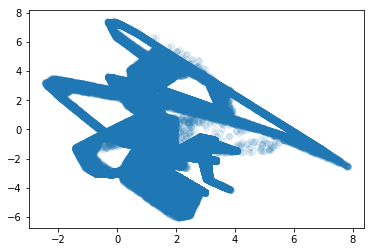

In [54]:
plt.scatter(gen[:,0],gen[:,1],alpha=0.1)

In [47]:
d = sample_data()

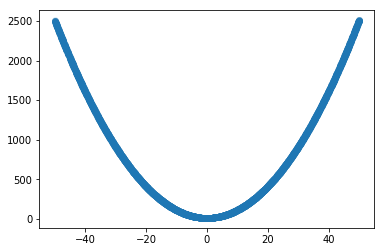

In [48]:
plt.scatter(d[:,0],d[:,1],alpha=0.1)